In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data, plot_latent_states 
from tools.ae_v2 import Autoencoder
from tools.hyper_param import trainAE_and_return_testError

In [8]:
strategy = None

In [9]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-19 14:44:21.434567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 14:44:21.435074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 14:44:21.502872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 14:44:21.503202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 14:44:21.503600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *


# loading data directory
data_dir_idx = '004'

# making ae save directory
dir_name_ae_nsb = os.getcwd() + dir_sep + 'saved_ae_ContractiveLmda_SearchBayes'
if not os.path.isdir(dir_name_ae_nsb):
    os.makedirs(dir_name_ae_nsb)

counter = 0
while True:
    dir_check = 'nsb_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_ae_nsb + dir_sep + dir_check):
        counter += 1
    else:
        break
        
dir_name_ae_nsb = dir_name_ae_nsb + dir_sep + dir_check
os.makedirs(dir_name_ae_nsb)
dir_name_aensb_plots = dir_name_ae_nsb+dir_sep+'plots'
os.makedirs(dir_name_aensb_plots)

print('dir_name_ae_nsb:', dir_name_ae_nsb)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae_nsb: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# dealing with normalizing the data before feeding into autoencoder

# normalize data before feeding into autoencoder?
normalizeforae_flag = True
normalization_type = 'stddev' # could be 'stddev' or 'minmax'
stddev_multiplier = 3
stddev_multiplier_pm = 1
num_params = params_mat.shape[1]

ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if ae_data_with_params == False:
    stddev_multiplier_pm = None
if normalizeforae_flag == False:
    stddev_multiplier = None

if ae_data_with_params == True and alldata_withparams_flag == False:
    new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
    new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
    del(all_data)
    all_data = new_all_data
    prev_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
        prev_idx = boundary_idx_arr[i]

normalization_constant_arr_aedata = None
if normalizeforae_flag == True:
    normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
    if normalization_type == 'stddev':
        sample_mean = np.mean(all_data, axis=0)
        sample_std = np.std(all_data, axis=0)
        normalization_constant_arr_aedata[0, :] = sample_mean
        normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
        if ae_data_with_params == True:
            normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
        zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
        if len(zero_idx) > 0:
            normalization_constant_arr_aedata[1, zero_idx] = 1.0
    elif normalization_type == 'minmax':
        for i in range(all_data.shape[1]):
            sample_min = np.min(all_data[:, i])
            sample_max = np.max(all_data[:, i])
            if sample_max - sample_min == 0:
                sample_min = sample_min - 0.5
                sample_max = sample_min + 1
            normalization_constant_arr_aedata[0, i] = sample_min
            normalization_constant_arr_aedata[1, i] = sample_max - sample_min
    # if ae_data_with_params == True:
    #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
    #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

# saving sim data
ae_data = {
    'data_dir_idx':data_dir_idx,
    'normalizeforae_flag':normalizeforae_flag,
    'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
    'normalization_type':normalization_type,
    'stddev_multiplier':stddev_multiplier,
    'stddev_multiplier_pm':stddev_multiplier_pm,
    'ae_data_with_params':ae_data_with_params,
    'module':Autoencoder.__module__,
}
with open(dir_name_ae_nsb+dir_sep+'ae_data.txt', 'w') as f:
    f.write(str(ae_data))
np.savez(
    dir_name_ae_nsb+dir_sep+'normalization_data',
    normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
)
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [21]:
normalization_constant_arr_aedata

array([[ 0.8598464 ,  0.20818995, -0.15084821, -0.4832867 , -0.19962065,
         0.18153833],
       [ 0.18234183,  0.22417355,  0.37001276,  0.33698028,  0.34491393,
         0.42713565]], dtype=float32)

# Autoencoder

In [22]:
# setting up training params
learning_rate_list = [1e-3, 1e-4]
epochs = 200
patience = 10  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 2**6
dt_ae = 0.2

# stddev = fRMS*timeMeanofSpaceRMS
# contractive_lmda = 0.0
fRMS = 7.79229715e-03
lambda_reg = 1.99491662e-06
use_weights_post_dense = True
dropout_rate = 0.0


# saving training params
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'contractive_lmda':contractive_lmda,
    'dropout_rate':dropout_rate,
    'dt_ae':dt_ae,
    'fRMS':fRMS,
    'lambda_reg':lambda_reg,
}

with open(dir_name_ae_nsb+dir_sep+'training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [23]:
all_data = all_data[0:370001]
boundary_idx_arr[0] = 370001

In [24]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = (num_elems_pre_indexing+skip_factor-1)//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [25]:
boundary_idx_arr

array([185001])

In [26]:
all_data.shape

(185001, 6)

In [27]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [28]:
#

In [29]:
# Initialize network
latent_space_dim = 5
# enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
# enc_layers = [192, 96, 48, 24, 12, 6, 3]
# enc_layers = [96, 48, 24, 12, 6, 3]
# enc_layers = [128, 64, 32, 16, 8, 4]
# enc_layers = []
# enc_layers = [32, 16, 8, 4]
# for i in range(len(enc_layers)):
#     if latent_space_dim < enc_layers[-i-1]:
#         enc_layers = enc_layers[0:-i]
#         break
#     if i == len(enc_layers)-1:
#         enc_layers = []
# dec_layers = enc_layers[::-1]
enc_layers = [16, 8, 8]
dec_layers = [8, 8, 16]

enc_layer_act_func = 'elu' #'modified_relu_2'
enc_final_layer_act_func = 'tanh'
dec_layer_act_func = 'elu' #'modified_relu_2'
dec_final_layer_act_func = 'tanh'
reg_name = 'L2'

In [30]:
#

In [31]:
def optim_func(
        x, # [contractive_lmda]
        time_stddev=time_stddev,
        Autoencoder=Autoencoder,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        readAndReturnLossHistories=readAndReturnLossHistories,
        plot_reconstructed_data=plot_reconstructed_data,
        plot_latent_states=plot_latent_states,
        dir_name_ae=dir_name_ae_nsb,
        training_data=training_data,
        testing_data=testing_data,
        val_data=val_data,
        boundary_idx_arr=boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        fRMS=fRMS,
        lambda_reg=lambda_reg,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name,
    ):
    
    test_mse = trainAE_and_return_testError(
        [fRMS, lambda_reg, x[0]], # [fRMS, lambda_reg]
        time_stddev,
        og_vars,
        Autoencoder,
        mytimecallback,
        SaveLosses,
        plot_losses,
        readAndReturnLossHistories,
        plot_reconstructed_data,
        plot_latent_states,
        dir_name_ae,
        training_data,
        testing_data,
        val_data,
        boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=None,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name
    )
    
    return test_mse

In [32]:
contractive_lmda_bounds = (1e-6, 1e-2, "log-uniform")
acq_func = "EI"
n_initial_points = 10
n_calls = n_initial_points + 20


optim_dict = {
    'contractive_lmda_bounds':contractive_lmda_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_ae_nsb + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [33]:
res = gp_minimize(
    optim_func,
    [contractive_lmda_bounds,],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2312/2313 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 0.0052 - NMSE: 0.0470 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.7230 - tot_time: 0h 0m 16.3s

Epoch 1: val_mse improved from inf to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 6ms/step - loss: 0.0054 - mse: 0.0052 - NMSE: 0.0470 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.7227 - val_loss:

Epoch 10/200
2313/2313 [==============================] - ETA: 0s - loss: 3.4905e-04 - mse: 7.6166e-05 - NMSE: 6.8550e-04 - real_MSE: 7.6166e-05 - params_MSE: nan - ls_jacobian_norm: 0.0985 - tot_time: 0h 2m 36.6s

Epoch 10: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.4905e-04 - mse: 7.6166e-05 - NMSE: 6.8550e-04 - real_MSE: 7.6166e-05 - params_MSE: nan - ls_jacobian_norm: 0.0985 - val_loss: 3.7007e-04 - val_mse: 9.6758e-05 - val_NMSE: 8.7083e-04 - val_real_MSE: 9.6758e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2313/2313 [==============================] - ETA: 0s - loss: 3.4527e-04 - mse: 7.1553e-05 - NMSE: 6.4398e-04 - real_MSE: 7.1553e-05 - params_MSE: nan - ls_jacobian_norm: 0.0953 - tot_time: 0h 2m 53.9s

Epoch 11: val_m

2309/2313 [============================>.] - ETA: 0s - loss: 3.3084e-04 - mse: 5.7116e-05 - NMSE: 5.1404e-04 - real_MSE: 5.7116e-05 - params_MSE: nan - ls_jacobian_norm: 0.0832 - tot_time: 0h 5m 22.8s

Epoch 20: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.3086e-04 - mse: 5.7134e-05 - NMSE: 5.1420e-04 - real_MSE: 5.7134e-05 - params_MSE: nan - ls_jacobian_norm: 0.0832 - val_loss: 3.3166e-04 - val_mse: 5.8172e-05 - val_NMSE: 5.2355e-04 - val_real_MSE: 5.8172e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2313/2313 [==============================] - ETA: 0s - loss: 3.2766e-04 - mse: 5.4135e-05 - NMSE: 4.8721e-04 - real_MSE: 5.4135e-05 - params_MSE: nan - ls_jacobian_norm: 0.0825 - tot_time: 0h 5m 39.2s

Epoch 21: val_mse improved f

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.2177e-04 - mse: 5.1941e-05 - NMSE: 4.6746e-04 - real_MSE: 5.1941e-05 - params_MSE: nan - ls_jacobian_norm: 0.0795 - val_loss: 3.2360e-04 - val_mse: 5.4144e-05 - val_NMSE: 4.8729e-04 - val_real_MSE: 5.4144e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.1908e-04 - mse: 4.9728e-05 - NMSE: 4.4755e-04 - real_MSE: 4.9728e-05 - params_MSE: nan - ls_jacobian_norm: 0.0794 - tot_time: 0h 8m 20.7s

Epoch 31: val_mse improved from 0.00004 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv

Epoch 41/200
2308/2313 [============================>.] - ETA: 0s - loss: 3.1467e-04 - mse: 4.7855e-05 - NMSE: 4.3069e-04 - real_MSE: 4.7855e-05 - params_MSE: nan - ls_jacobian_norm: 0.0775Restoring model weights from the end of the best epoch: 31.
 - tot_time: 0h 11m 10.3s

Epoch 41: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.1466e-04 - mse: 4.7849e-05 - NMSE: 4.3064e-04 - real_MSE: 4.7849e-05 - params_MSE: nan - ls_jacobian_norm: 0.0775 - val_loss: 3.0032e-04 - val_mse: 3.3790e-05 - val_NMSE: 3.0411e-04 - val_real_MSE: 3.3790e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 --------

2307/2313 [============================>.] - ETA: 0s - loss: 3.0539e-04 - mse: 3.0707e-05 - NMSE: 2.7637e-04 - real_MSE: 3.0707e-05 - params_MSE: nan - ls_jacobian_norm: 0.0740 - tot_time: 0h 13m 44.8s

Epoch 9: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 8ms/step - loss: 3.0540e-04 - mse: 3.0717e-05 - NMSE: 2.7646e-04 - real_MSE: 3.0717e-05 - params_MSE: nan - ls_jacobian_norm: 0.0740 - val_loss: 3.0060e-04 - val_mse: 2.5750e-05 - val_NMSE: 2.3175e-04 - val_real_MSE: 2.5750e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2312/2313 [============================>.] - ETA: 0s - loss: 3.0571e-04 - mse: 3.0697e-05 - NMSE: 2.7627e-04 - real_MSE: 3.0697e-05 - params_MSE: nan - ls_jacobian_norm: 0.0737 - tot_time: 0h 14m 2.6s

Epoch 10: val_mse did not im

Epoch 2/200
2310/2313 [============================>.] - ETA: 0s - loss: 4.7623e-04 - mse: 3.0139e-04 - NMSE: 0.0027 - real_MSE: 3.0139e-04 - params_MSE: nan - ls_jacobian_norm: 1.3712 - tot_time: 0h 0m 33.9s

Epoch 2: val_mse improved from 0.00053 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 4.7610e-04 - mse: 3.0126e-04 - NMSE: 0.0027 - real_MSE: 3.0126e-04 - params_MSE: nan - ls_jacobian_norm: 1.3713 - val_loss: 3.7618e-04 - val_mse: 2.0057e-04 - val_NMSE: 0.0018 - val_real_MSE: 2.0057e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.1939e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.9858e-04 - mse: 4.7041e-05 - NMSE: 4.2337e-04 - real_MSE: 4.7041e-05 - params_MSE: nan - ls_jacobian_norm: 1.2515 - val_loss: 1.9170e-04 - val_mse: 4.1089e-05 - val_NMSE: 3.6980e-04 - val_real_MSE: 4.1089e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.9449e-04 - mse: 4.4709e-05 - NMSE: 4.0238e-04 - real_MSE: 4.4709e-05 - params_MSE: nan - ls_jacobian_norm: 1.2411 - tot_time: 0h 3m 24.4s

Epoch 12: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/

2312/2313 [============================>.] - ETA: 0s - loss: 1.7649e-04 - mse: 3.5368e-05 - NMSE: 3.1831e-04 - real_MSE: 3.5368e-05 - params_MSE: nan - ls_jacobian_norm: 1.2014 - tot_time: 0h 5m 30.4s

Epoch 21: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.7649e-04 - mse: 3.5366e-05 - NMSE: 3.1829e-04 - real_MSE: 3.5366e-05 - params_MSE: nan - ls_jacobian_norm: 1.2014 - val_loss: 1.7302e-04 - val_mse: 3.2088e-05 - val_NMSE: 2.8879e-04 - val_real_MSE: 3.2088e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2304/2313 [============================>.] - ETA: 0s - loss: 1.7588e-04 - mse: 3.5250e-05 - NMSE: 3.1725e-04 - real_MSE: 3.5250e-05 - params_MSE: nan - ls_jacobian_norm: 1.2016 - tot_time: 0h 5m 41.6s

Epoch 22: val_mse improved f

Epoch 31/200
2313/2313 [==============================] - ETA: 0s - loss: 1.6987e-04 - mse: 3.2191e-05 - NMSE: 2.8972e-04 - real_MSE: 3.2191e-05 - params_MSE: nan - ls_jacobian_norm: 1.2157 - tot_time: 0h 7m 41.4s

Epoch 31: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6987e-04 - mse: 3.2191e-05 - NMSE: 2.8972e-04 - real_MSE: 3.2191e-05 - params_MSE: nan - ls_jacobian_norm: 1.2157 - val_loss: 1.6637e-04 - val_mse: 2.8745e-05 - val_NMSE: 2.5870e-04 - val_real_MSE: 2.8745e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.6945e-04 - mse: 3.1907e-05 - NMSE: 2.8716e-04 - real_MSE: 3.1907e-05 - params_MSE: nan - ls_jacobian_norm: 1.2155 - tot_time: 0h 7m 54.9s

Epoch 32: val_m

Epoch 6/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.6520e-04 - mse: 2.5938e-05 - NMSE: 2.3345e-04 - real_MSE: 2.5938e-05 - params_MSE: nan - ls_jacobian_norm: 1.1880 - tot_time: 0h 9m 40.2s

Epoch 6: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 1.6519e-04 - mse: 2.5937e-05 - NMSE: 2.3343e-04 - real_MSE: 2.5937e-05 - params_MSE: nan - ls_jacobian_norm: 1.1880 - val_loss: 1.6057e-04 - val_mse: 2.1294e-05 - val_NMSE: 1.9165e-04 - val_real_MSE: 2.1294e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.

2307/2313 [============================>.] - ETA: 0s - loss: 1.6408e-04 - mse: 2.5079e-05 - NMSE: 2.2571e-04 - real_MSE: 2.5079e-05 - params_MSE: nan - ls_jacobian_norm: 1.1706Restoring model weights from the end of the best epoch: 6.
 - tot_time: 0h 12m 12.1s

Epoch 16: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 6ms/step - loss: 1.6408e-04 - mse: 2.5073e-05 - NMSE: 2.2565e-04 - real_MSE: 2.5073e-05 - params_MSE: nan - ls_jacobian_norm: 1.1706 - val_loss: 1.6002e-04 - val_mse: 2.1050e-05 - val_NMSE: 1.8945e-04 - val_real_MSE: 2.1050e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16: early stopping
579/579 [==============================] - 1s 2ms/step - loss: 1.6057e-04 - mse: 2.1294e-05 - NMSE: 1.9165e-04 - real_MSE: 2.1294e-05 - params_MSE: nan - ls_j

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 3.4488e-04 - mse: 8.2804e-05 - NMSE: 7.4523e-04 - real_MSE: 8.2804e-05 - params_MSE: nan - ls_jacobian_norm: 0.1175 - val_loss: 3.2661e-04 - val_mse: 6.3718e-05 - val_NMSE: 5.7346e-04 - val_real_MSE: 6.3718e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2311/2313 [============================>.] - ETA: 0s - loss: 3.3925e-04 - mse: 7.5388e-05 - NMSE: 6.7849e-04 - real_MSE: 7.5388e-05 - params_MSE: nan - ls_jacobian_norm: 0.1116 - tot_time: 0h 1m 57.3s

Epoch 9: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/st

2311/2313 [============================>.] - ETA: 0s - loss: 3.2083e-04 - mse: 5.5620e-05 - NMSE: 5.0058e-04 - real_MSE: 5.5620e-05 - params_MSE: nan - ls_jacobian_norm: 0.0928 - tot_time: 0h 4m 17.9s

Epoch 18: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 3.2082e-04 - mse: 5.5616e-05 - NMSE: 5.0055e-04 - real_MSE: 5.5616e-05 - params_MSE: nan - ls_jacobian_norm: 0.0928 - val_loss: 3.1742e-04 - val_mse: 5.2455e-05 - val_NMSE: 4.7209e-04 - val_real_MSE: 5.2455e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
2302/2313 [============================>.] - ETA: 0s - loss: 3.1975e-04 - mse: 5.5023e-05 - NMSE: 4.9521e-04 - real_MSE: 5.5023e-05 - params_MSE: nan - ls_jacobian_norm: 0.0922 - tot_time: 0h 4m 33.7s

Epoch 19: val_mse did not im

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 3.1029e-04 - mse: 4.9026e-05 - NMSE: 4.4124e-04 - real_MSE: 4.9026e-05 - params_MSE: nan - ls_jacobian_norm: 0.0879 - val_loss: 3.1007e-04 - val_mse: 4.8848e-05 - val_NMSE: 4.3963e-04 - val_real_MSE: 4.8848e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
2305/2313 [============================>.] - ETA: 0s - loss: 3.1000e-04 - mse: 4.8966e-05 - NMSE: 4.4069e-04 - real_MSE: 4.8966e-05 - params_MSE: nan - ls_jacobian_norm: 0.0875 - tot_time: 0h 6m 39.0s

Epoch 29: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/

Epoch 39/200
2313/2313 [==============================] - ETA: 0s - loss: 3.0350e-04 - mse: 4.5645e-05 - NMSE: 4.1081e-04 - real_MSE: 4.5645e-05 - params_MSE: nan - ls_jacobian_norm: 0.0856 - tot_time: 0h 8m 37.1s

Epoch 39: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 3.0350e-04 - mse: 4.5645e-05 - NMSE: 4.1081e-04 - real_MSE: 4.5645e-05 - params_MSE: nan - ls_jacobian_norm: 0.0856 - val_loss: 3.0454e-04 - val_mse: 4.6845e-05 - val_NMSE: 4.2160e-04 - val_real_MSE: 4.6845e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
2313/2313 [==============================] - ETA: 0s - loss: 3.0257e-04 - mse: 4.4957e-05 - NMSE: 4.0461e-04 - real_MSE: 4.4957e-05 - params_MSE: nan - ls_jacobian_norm: 0.0855 - tot_time: 0h 8m 49.0s

Epoch 40: val_m

Epoch 8/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.9470e-04 - mse: 3.0245e-05 - NMSE: 2.7220e-04 - real_MSE: 3.0245e-05 - params_MSE: nan - ls_jacobian_norm: 0.0821 - tot_time: 0h 10m 35.4s

Epoch 8: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.9470e-04 - mse: 3.0242e-05 - NMSE: 2.7217e-04 - real_MSE: 3.0242e-05 - params_MSE: nan - ls_jacobian_norm: 0.0821 - val_loss: 2.8936e-04 - val_mse: 2.4738e-05 - val_NMSE: 2.2264e-04 - val_real_MSE: 2.4738e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.9483e-04 - mse: 3.0053e-05 - NMSE: 2.7048e-04 - real_MSE: 3.0053e-05 - params_MSE: nan - ls_jacobian_norm: 0.0817 - tot_time: 0h 10m 47.5s

Epoch 9: val_mse

Epoch 19/200
2303/2313 [============================>.] - ETA: 0s - loss: 2.9581e-04 - mse: 2.9371e-05 - NMSE: 2.6434e-04 - real_MSE: 2.9371e-05 - params_MSE: nan - ls_jacobian_norm: 0.0793 - tot_time: 0h 12m 43.3s

Epoch 19: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.9582e-04 - mse: 2.9375e-05 - NMSE: 2.6438e-04 - real_MSE: 2.9375e-05 - params_MSE: nan - ls_jacobian_norm: 0.0793 - val_loss: 2.9035e-04 - val_mse: 2.3858e-05 - val_NMSE: 2.1472e-04 - val_real_MSE: 2.3858e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2313/2313 [==============================] - ETA: 0s - loss

2309/2313 [============================>.] - ETA: 0s - loss: 2.6572e-04 - mse: 6.7339e-05 - NMSE: 6.0605e-04 - real_MSE: 6.7339e-05 - params_MSE: nan - ls_jacobian_norm: 0.3215 - tot_time: 0h 1m 24.3s

Epoch 7: val_mse improved from 0.00006 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 2.6569e-04 - mse: 6.7314e-05 - NMSE: 6.0582e-04 - real_MSE: 6.7314e-05 - params_MSE: nan - ls_jacobian_norm: 0.3214 - val_loss: 2.5893e-04 - val_mse: 6.0881e-05 - val_NMSE: 5.4793e-04 - val_real_MSE: 6.0881e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.5962e-04 - m

Epoch 17/200
2309/2313 [============================>.] - ETA: 0s - loss: 2.3438e-04 - mse: 4.4685e-05 - NMSE: 4.0217e-04 - real_MSE: 4.4685e-05 - params_MSE: nan - ls_jacobian_norm: 0.2551 - tot_time: 0h 3m 19.6s

Epoch 17: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 2.3439e-04 - mse: 4.4701e-05 - NMSE: 4.0231e-04 - real_MSE: 4.4701e-05 - params_MSE: nan - ls_jacobian_norm: 0.2551 - val_loss: 2.5474e-04 - val_mse: 6.5404e-05 - val_NMSE: 5.8864e-04 - val_real_MSE: 6.5404e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
2306/2313 [============================>.] - ETA: 0s - loss: 2.3304e-04 - mse: 4.4094e-05 - NMSE: 3.9684e-04 - real_MSE: 4.4094e-05 - params_MSE: nan - ls_jacobian_norm: 0.2536 - tot_time: 0h 3m 31.1s

Epoch 18: val_m

Epoch 28/200
2305/2313 [============================>.] - ETA: 0s - loss: 2.2249e-04 - mse: 3.8667e-05 - NMSE: 3.4800e-04 - real_MSE: 3.8667e-05 - params_MSE: nan - ls_jacobian_norm: 0.2438 - tot_time: 0h 5m 26.7s

Epoch 28: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.2248e-04 - mse: 3.8656e-05 - NMSE: 3.4791e-04 - real_MSE: 3.8656e-05 - params_MSE: nan - ls_jacobian_norm: 0.2438 - val_loss: 2.2004e-04 - val_mse: 3.6413e-05 - val_NMSE: 3.2772e-04 - val_real_MSE: 3.6413e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.2169e-04 - mse: 3.8258e-05 - NMSE: 3.4432e-04 - real_MSE: 3.8258e-05 - params_MSE: nan - ls_jacobian_norm: 0.2434Restoring model weights from the end of t

Epoch 9/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.1967e-04 - mse: 2.9921e-05 - NMSE: 2.6929e-04 - real_MSE: 2.9921e-05 - params_MSE: nan - ls_jacobian_norm: 0.2378 - tot_time: 0h 8m 5.1s

Epoch 9: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.1968e-04 - mse: 2.9931e-05 - NMSE: 2.6938e-04 - real_MSE: 2.9931e-05 - params_MSE: nan - ls_jacobian_norm: 0.2378 - val_loss: 2.1571e-04 - val_mse: 2.5932e-05 - val_NMSE: 2.3339e-04 - val_real_MSE: 2.5932e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2309/2313 [============================>.] - ETA: 0s - loss: 2.1964e-04 - mse: 2.9830e-05 - NMSE: 2.6847e-04 - real_MSE: 2.9830e-05 - params_MSE: nan - ls_jacobian_norm: 0.2369 - tot_time: 0h 8m 21.9s

Epoch 10: val_mse 

2310/2313 [============================>.] - ETA: 0s - loss: 2.1871e-04 - mse: 2.8857e-05 - NMSE: 2.5971e-04 - real_MSE: 2.8857e-05 - params_MSE: nan - ls_jacobian_norm: 0.2312 - tot_time: 0h 10m 48.9s

Epoch 19: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.1871e-04 - mse: 2.8858e-05 - NMSE: 2.5972e-04 - real_MSE: 2.8858e-05 - params_MSE: nan - ls_jacobian_norm: 0.2312 - val_loss: 2.1434e-04 - val_mse: 2.4501e-05 - val_NMSE: 2.2051e-04 - val_real_MSE: 2.4501e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2313/2313 [==============================] - ETA: 0s - loss: 2.1867e-04 - mse: 2.8854e-05 - NMSE: 2.5969e-04 - real_MSE: 2.8854e-05 - params_MSE: nan - ls_jacobian_norm: 0.2308 - tot_time: 0h 11m 4.2s

Epoch 20: val_mse did not i

2305/2313 [============================>.] - ETA: 0s - loss: 4.8268e-04 - mse: 3.0693e-04 - NMSE: 0.0028 - real_MSE: 3.0693e-04 - params_MSE: nan - ls_jacobian_norm: 1.1398 - tot_time: 0h 0m 31.7s

Epoch 2: val_mse improved from 0.00053 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.8238e-04 - mse: 3.0663e-04 - NMSE: 0.0028 - real_MSE: 3.0663e-04 - params_MSE: nan - ls_jacobian_norm: 1.1394 - val_loss: 3.9692e-04 - val_mse: 2.1965e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.1965e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2311/2313 [============================>.] - ETA: 0s - loss: 3.2709e-04 - mse: 1.4884e-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 2.1186e-04 - mse: 4.6630e-05 - NMSE: 4.1967e-04 - real_MSE: 4.6630e-05 - params_MSE: nan - ls_jacobian_norm: 0.5631 - val_loss: 2.0226e-04 - val_mse: 3.7778e-05 - val_NMSE: 3.4000e-04 - val_real_MSE: 3.7778e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.0836e-04 - mse: 4.4632e-05 - NMSE: 4.0168e-04 - real_MSE: 4.4632e-05 - params_MSE: nan - ls_jacobian_norm: 0.5541 - tot_time: 0h 3m 10.2s

Epoch 12: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/

Epoch 22/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.9141e-04 - mse: 3.6160e-05 - NMSE: 3.2544e-04 - real_MSE: 3.6160e-05 - params_MSE: nan - ls_jacobian_norm: 0.5261 - tot_time: 0h 5m 47.6s

Epoch 22: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.9141e-04 - mse: 3.6159e-05 - NMSE: 3.2543e-04 - real_MSE: 3.6159e-05 - params_MSE: nan - ls_jacobian_norm: 0.5261 - val_loss: 1.8533e-04 - val_mse: 3.0375e-05 - val_NMSE: 2.7338e-04 - val_real_MSE: 3.0375e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2303/2313 [============================>.] - ETA: 0s - loss:

Epoch 32/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.8513e-04 - mse: 3.3044e-05 - NMSE: 2.9740e-04 - real_MSE: 3.3044e-05 - params_MSE: nan - ls_jacobian_norm: 0.5208 - tot_time: 0h 8m 29.0s

Epoch 32: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.8513e-04 - mse: 3.3052e-05 - NMSE: 2.9746e-04 - real_MSE: 3.3052e-05 - params_MSE: nan - ls_jacobian_norm: 0.5208 - val_loss: 1.8743e-04 - val_mse: 3.5562e-05 - val_NMSE: 3.2006e-04 - val_real_MSE: 3.5562e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.8478e-04 - mse: 3.2939e-05 - NMSE: 2.9645e-04 - real_MSE: 3.2939e-05 - params_MSE: nan - ls_jacobian_norm: 0.5201 - tot_time: 0h 8m 45.7s

Epoch 33: val_m

2313/2313 [==============================] - ETA: 0s - loss: 1.8171e-04 - mse: 3.1109e-05 - NMSE: 2.7998e-04 - real_MSE: 3.1109e-05 - params_MSE: nan - ls_jacobian_norm: 0.5164 - tot_time: 0h 11m 11.0s

Epoch 42: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.8171e-04 - mse: 3.1109e-05 - NMSE: 2.7998e-04 - real_MSE: 3.1109e-05 - params_MSE: nan - ls_jacobian_norm: 0.5164 - val_loss: 1.7564e-04 - val_mse: 2.5159e-05 - val_NMSE: 2.2643e-04 - val_real_MSE: 2.5159e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.8145e-04 - mse: 3.1013e-05 - NMSE: 2.7911e-04 - real_MSE: 3.1013e-05 - params_MSE: nan - ls_jacobian_norm: 0.5165 - tot_time: 0h 11m 27.5s

Epoch 43: val_mse did not 

Epoch 4/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.7556e-04 - mse: 2.3994e-05 - NMSE: 2.1595e-04 - real_MSE: 2.3994e-05 - params_MSE: nan - ls_jacobian_norm: 0.5087 - tot_time: 0h 13m 45.4s

Epoch 4: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7555e-04 - mse: 2.3987e-05 - NMSE: 2.1588e-04 - real_MSE: 2.3987e-05 - params_MSE: nan - ls_jacobian_norm: 0.5087 - val_loss: 1.7196e-04 - val_mse: 2.0366e-05 - val_NMSE: 1.8330e-04 - val_real_MSE: 2.0366e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.7553e-04 - mse: 2.3881e-05 - NMSE: 2.1492e-04 - real_MSE: 2.3881e-05 - params_MSE: nan - ls_jacobian_norm: 0.5070 - tot_time: 0h 14m 1.6s

Epoch 5: val_mse 

2309/2313 [============================>.] - ETA: 0s - loss: 1.7560e-04 - mse: 2.3526e-05 - NMSE: 2.1173e-04 - real_MSE: 2.3526e-05 - params_MSE: nan - ls_jacobian_norm: 0.4971 - tot_time: 0h 16m 26.6s

Epoch 14: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.7560e-04 - mse: 2.3525e-05 - NMSE: 2.1172e-04 - real_MSE: 2.3525e-05 - params_MSE: nan - ls_jacobian_norm: 0.4971 - val_loss: 1.7147e-04 - val_mse: 1.9392e-05 - val_NMSE: 1.7453e-04 - val_real_MSE: 1.9392e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.7553e-04 - mse: 2.3448e-05 - NMSE: 2.1103e-04 - real_MSE: 2.3448e-05 - params_MSE: nan - ls_jacobian_norm: 0.4964 - tot_time: 0h 16m 43.1s

Epoch 15: val_mse improved

2310/2313 [============================>.] - ETA: 0s - loss: 4.7598e-04 - mse: 3.0117e-04 - NMSE: 0.0027 - real_MSE: 3.0117e-04 - params_MSE: nan - ls_jacobian_norm: 1.3868 - tot_time: 0h 0m 32.9s

Epoch 2: val_mse improved from 0.00053 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 4.7585e-04 - mse: 3.0104e-04 - NMSE: 0.0027 - real_MSE: 3.0104e-04 - params_MSE: nan - ls_jacobian_norm: 1.3868 - val_loss: 3.7524e-04 - val_mse: 1.9968e-04 - val_NMSE: 0.0018 - val_real_MSE: 1.9968e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2308/2313 [============================>.] - ETA: 0s - loss: 3.1925e-04 - mse: 1.4379e-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.9831e-04 - mse: 4.7388e-05 - NMSE: 4.2649e-04 - real_MSE: 4.7388e-05 - params_MSE: nan - ls_jacobian_norm: 1.4071 - val_loss: 1.9391e-04 - val_mse: 4.3939e-05 - val_NMSE: 3.9545e-04 - val_real_MSE: 4.3939e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.9422e-04 - mse: 4.5105e-05 - NMSE: 4.0594e-04 - real_MSE: 4.5105e-05 - params_MSE: nan - ls_jacobian_norm: 1.4026 - tot_time: 0h 3m 17.4s

Epoch 12: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/

2304/2313 [============================>.] - ETA: 0s - loss: 1.7611e-04 - mse: 3.5784e-05 - NMSE: 3.2206e-04 - real_MSE: 3.5784e-05 - params_MSE: nan - ls_jacobian_norm: 1.3758 - tot_time: 0h 5m 43.4s

Epoch 21: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 1.7610e-04 - mse: 3.5773e-05 - NMSE: 3.2196e-04 - real_MSE: 3.5773e-05 - params_MSE: nan - ls_jacobian_norm: 1.3758 - val_loss: 1.7172e-04 - val_mse: 3.1586e-05 - val_NMSE: 2.8428e-04 - val_real_MSE: 3.1586e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2313/2313 [==============================] - ETA: 0s - loss: 1.7549e-04 - mse: 3.5654e-05 - NMSE: 3.2089e-04 - real_MSE: 3.5654e-05 - params_MSE: nan - ls_jacobian_norm: 1.3759 - tot_time: 0h 5m 59.1s

Epoch 22: val_mse improved f

2302/2313 [============================>.] - ETA: 0s - loss: 1.6945e-04 - mse: 3.2553e-05 - NMSE: 2.9298e-04 - real_MSE: 3.2553e-05 - params_MSE: nan - ls_jacobian_norm: 1.3867 - tot_time: 0h 8m 26.4s

Epoch 31: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6944e-04 - mse: 3.2540e-05 - NMSE: 2.9286e-04 - real_MSE: 3.2540e-05 - params_MSE: nan - ls_jacobian_norm: 1.3867 - val_loss: 1.6289e-04 - val_mse: 2.6051e-05 - val_NMSE: 2.3446e-04 - val_real_MSE: 2.6051e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.6895e-04 -

Epoch 4/200
2305/2313 [============================>.] - ETA: 0s - loss: 1.6384e-04 - mse: 2.5958e-05 - NMSE: 2.3362e-04 - real_MSE: 2.5958e-05 - params_MSE: nan - ls_jacobian_norm: 1.3672 - tot_time: 0h 11m 7.8s

Epoch 4: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6383e-04 - mse: 2.5947e-05 - NMSE: 2.3352e-04 - real_MSE: 2.5947e-05 - params_MSE: nan - ls_jacobian_norm: 1.3672 - val_loss: 1.5943e-04 - val_mse: 2.1566e-05 - val_NMSE: 1.9409e-04 - val_real_MSE: 2.1566e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.

2311/2313 [============================>.] - ETA: 0s - loss: 1.6282e-04 - mse: 2.5116e-05 - NMSE: 2.2605e-04 - real_MSE: 2.5116e-05 - params_MSE: nan - ls_jacobian_norm: 1.3430 - tot_time: 0h 13m 47.1s

Epoch 14: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.6283e-04 - mse: 2.5120e-05 - NMSE: 2.2608e-04 - real_MSE: 2.5120e-05 - params_MSE: nan - ls_jacobian_norm: 1.3430 - val_loss: 1.5881e-04 - val_mse: 2.1097e-05 - val_NMSE: 1.8988e-04 - val_real_MSE: 2.1097e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.6274e-04 - mse: 2.5067e-05 - NMSE: 2.2560e-04 - real_MSE: 2.5067e-05 - params_MSE: nan - ls_jacobian_norm: 1.3416 - tot_time: 0h 14m 3.8s

Epoch 15: val_mse improved 

2306/2313 [============================>.] - ETA: 0s - loss: 2.4539e-04 - mse: 6.8389e-05 - NMSE: 6.1550e-04 - real_MSE: 6.8389e-05 - params_MSE: nan - ls_jacobian_norm: 0.6486 - tot_time: 0h 1m 36.2s

Epoch 6: val_mse improved from 0.00006 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 2.4537e-04 - mse: 6.8379e-05 - NMSE: 6.1541e-04 - real_MSE: 6.8379e-05 - params_MSE: nan - ls_jacobian_norm: 0.6485 - val_loss: 2.3712e-04 - val_mse: 6.1226e-05 - val_NMSE: 5.5103e-04 - val_real_MSE: 6.1226e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.3590e-04 - m

Epoch 16/200
2305/2313 [============================>.] - ETA: 0s - loss: 2.0061e-04 - mse: 3.9595e-05 - NMSE: 3.5635e-04 - real_MSE: 3.9595e-05 - params_MSE: nan - ls_jacobian_norm: 0.5056 - tot_time: 0h 3m 39.9s

Epoch 16: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.0060e-04 - mse: 3.9583e-05 - NMSE: 3.5625e-04 - real_MSE: 3.9583e-05 - params_MSE: nan - ls_jacobian_norm: 0.5056 - val_loss: 1.9831e-04 - val_mse: 3.7830e-05 - val_NMSE: 3.4047e-04 - val_real_MSE: 3.7830e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.9907e-04 - mse: 3.8930e-05 - NMSE: 3.5037e-04 - real_MSE: 3.8930e-05 - params_MSE: nan - ls_jacobian_norm: 0.5032 - tot_time: 0h 3m 51.7s

Epoch 17: val_m

2312/2313 [============================>.] - ETA: 0s - loss: 1.9034e-04 - mse: 3.4935e-05 - NMSE: 3.1441e-04 - real_MSE: 3.4935e-05 - params_MSE: nan - ls_jacobian_norm: 0.4932 - tot_time: 0h 6m 7.5s

Epoch 26: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 18s 8ms/step - loss: 1.9034e-04 - mse: 3.4936e-05 - NMSE: 3.1443e-04 - real_MSE: 3.4936e-05 - params_MSE: nan - ls_jacobian_norm: 0.4932 - val_loss: 1.8551e-04 - val_mse: 3.0206e-05 - val_NMSE: 2.7185e-04 - val_real_MSE: 3.0206e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.8936e-04 - mse: 3.4243e-05 - NMSE: 3.0819e-04 - real_MSE: 3.4243e-05 - params_MSE: nan - ls_jacobian_norm: 0.4926 - tot_time: 0h 6m 25.9s

Epoch 27: val_mse did not imp

Epoch 3/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.8349e-04 - mse: 2.6718e-05 - NMSE: 2.4046e-04 - real_MSE: 2.6718e-05 - params_MSE: nan - ls_jacobian_norm: 0.4876 - tot_time: 0h 8m 51.5s

Epoch 3: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.8349e-04 - mse: 2.6718e-05 - NMSE: 2.4046e-04 - real_MSE: 2.6718e-05 - params_MSE: nan - ls_jacobian_norm: 0.4876 - val_loss: 1.8001e-04 - val_mse: 2.3184e-05 - val_NMSE: 2.0865e-04 - val_real_MSE: 2.3184e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.8350e-04 - mse: 2.6635e-05 - NMSE: 2.3972e-04 - real_MSE: 2.6635e-05 - params_MSE: nan - ls_jacobian_norm: 0.4853 - tot_time: 0h 9m 7.3s

Epoch 4: val_mse di

Epoch 13/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.8296e-04 - mse: 2.5845e-05 - NMSE: 2.3260e-04 - real_MSE: 2.5845e-05 - params_MSE: nan - ls_jacobian_norm: 0.4728 - tot_time: 0h 11m 6.9s

Epoch 13: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 5ms/step - loss: 1.8296e-04 - mse: 2.5845e-05 - NMSE: 2.3261e-04 - real_MSE: 2.5845e-05 - params_MSE: nan - ls_jacobian_norm: 0.4728 - val_loss: 1.7896e-04 - val_mse: 2.1852e-05 - val_NMSE: 1.9667e-04 - val_real_MSE: 2.1852e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.8281e-04 - mse: 2.5711e-05 - NMSE: 2.3140e-04 - real_MSE: 2.5711e-05 - params_MSE: nan - ls_jacobian_norm: 0.4719 - tot_time: 0h 11m 19.2s

Epoch 14: val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.4951e-04 - mse: 7.7197e-05 - NMSE: 6.9477e-04 - real_MSE: 7.7197e-05 - params_MSE: nan - ls_jacobian_norm: 1.0533 - val_loss: 2.3962e-04 - val_mse: 6.8972e-05 - val_NMSE: 6.2074e-04 - val_real_MSE: 6.8972e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.3605e-04 - mse: 6.7088e-05 - NMSE: 6.0379e-04 - real_MSE: 6.7088e-05 - params_MSE: nan - ls_jacobian_norm: 0.9972 - tot_time: 0h 1m 16.9s

Epoch 6: val_mse improved from 0.00007 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/s

Epoch 15/200
2310/2313 [============================>.] - ETA: 0s - loss: 1.8956e-04 - mse: 3.9306e-05 - NMSE: 3.5376e-04 - real_MSE: 3.9306e-05 - params_MSE: nan - ls_jacobian_norm: 0.8216 - tot_time: 0h 3m 4.9s

Epoch 15: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.8956e-04 - mse: 3.9304e-05 - NMSE: 3.5374e-04 - real_MSE: 3.9304e-05 - params_MSE: nan - ls_jacobian_norm: 0.8216 - val_loss: 1.8837e-04 - val_mse: 3.8561e-05 - val_NMSE: 3.4705e-04 - val_real_MSE: 3.8561e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2310/2313 [============================>.] - ETA: 0s - loss: 1.8750e-04 - mse: 3.8186e-05 - NMSE: 3.4368e-04 - real_MSE: 3.8186e-05 - params_MSE: nan - ls_jacobian_norm: 0.8182 - tot_time: 0h 3m 17.2s

Epoch 16: val_ms

Epoch 25/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.7748e-04 - mse: 3.3385e-05 - NMSE: 3.0046e-04 - real_MSE: 3.3385e-05 - params_MSE: nan - ls_jacobian_norm: 0.8063 - tot_time: 0h 5m 5.3s

Epoch 25: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.7750e-04 - mse: 3.3403e-05 - NMSE: 3.0063e-04 - real_MSE: 3.3403e-05 - params_MSE: nan - ls_jacobian_norm: 0.8063 - val_loss: 1.7269e-04 - val_mse: 2.8756e-05 - val_NMSE: 2.5880e-04 - val_real_MSE: 2.8756e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
2313/2313 [==============================] - ETA: 0s - loss: 1.7712e-04 - mse: 3.3421e-05 - NMSE: 3.0079e-04 - real_MSE: 3.3421e-05 - params_MSE: nan - ls_jacobian_norm: 0.8066 - tot_time: 0h 5m 17.4s

Epoch 26: val_ms

2312/2313 [============================>.] - ETA: 0s - loss: 1.7294e-04 - mse: 3.1342e-05 - NMSE: 2.8208e-04 - real_MSE: 3.1342e-05 - params_MSE: nan - ls_jacobian_norm: 0.8080 - tot_time: 0h 7m 4.8s

Epoch 35: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.7294e-04 - mse: 3.1344e-05 - NMSE: 2.8209e-04 - real_MSE: 3.1344e-05 - params_MSE: nan - ls_jacobian_norm: 0.8080 - val_loss: 1.7449e-04 - val_mse: 3.3005e-05 - val_NMSE: 2.9704e-04 - val_real_MSE: 3.3005e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.7289e-04 - mse: 3.1493e-05 - NMSE: 2.8344e-04 - real_MSE: 3.1493e-05 - params_MSE: nan - ls_jacobian_norm: 0.8085 - tot_time: 0h 7m 16.7s

Epoch 36: val_mse did not imp

Epoch 5/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.6725e-04 - mse: 2.4486e-05 - NMSE: 2.2038e-04 - real_MSE: 2.4486e-05 - params_MSE: nan - ls_jacobian_norm: 0.7938 - tot_time: 0h 9m 5.5s

Epoch 5: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.6726e-04 - mse: 2.4494e-05 - NMSE: 2.2045e-04 - real_MSE: 2.4494e-05 - params_MSE: nan - ls_jacobian_norm: 0.7938 - val_loss: 1.6375e-04 - val_mse: 2.0947e-05 - val_NMSE: 1.8852e-04 - val_real_MSE: 2.0947e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.6725e-04 - mse: 2.4453e-05 - NMSE: 2.2007e-04 - real_MSE: 2.4453e-05 - params_MSE: nan - ls_jacobian_norm: 0.7915 - tot_time: 0h 9m 17.7s

Epoch 6: val_mse im

Epoch 3/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.1929e-04 - mse: 1.4379e-04 - NMSE: 0.0013 - real_MSE: 1.4379e-04 - params_MSE: nan - ls_jacobian_norm: 1.4414 - tot_time: 0h 0m 36.8s

Epoch 3: val_mse improved from 0.00020 to 0.00012, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 3.1925e-04 - mse: 1.4375e-04 - NMSE: 0.0013 - real_MSE: 1.4375e-04 - params_MSE: nan - ls_jacobian_norm: 1.4414 - val_loss: 2.9494e-04 - val_mse: 1.2003e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2003e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2303/2313 [============================>.] - ETA: 0s - loss: 2.6993e-04 - m

Epoch 13/200
2304/2313 [============================>.] - ETA: 0s - loss: 1.9116e-04 - mse: 4.3380e-05 - NMSE: 3.9042e-04 - real_MSE: 4.3380e-05 - params_MSE: nan - ls_jacobian_norm: 1.3203 - tot_time: 0h 2m 31.0s

Epoch 13: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 1.9118e-04 - mse: 4.3401e-05 - NMSE: 3.9061e-04 - real_MSE: 4.3401e-05 - params_MSE: nan - ls_jacobian_norm: 1.3202 - val_loss: 1.8714e-04 - val_mse: 4.0106e-05 - val_NMSE: 3.6095e-04 - val_real_MSE: 4.0106e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2312/2313 [============================>.] - ETA: 0s - loss:

Epoch 23/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.7439e-04 - mse: 3.4752e-05 - NMSE: 3.1277e-04 - real_MSE: 3.4752e-05 - params_MSE: nan - ls_jacobian_norm: 1.2934 - tot_time: 0h 4m 25.0s

Epoch 23: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 1.7440e-04 - mse: 3.4764e-05 - NMSE: 3.1287e-04 - real_MSE: 3.4764e-05 - params_MSE: nan - ls_jacobian_norm: 1.2934 - val_loss: 1.6900e-04 - val_mse: 2.9423e-05 - val_NMSE: 2.6481e-04 - val_real_MSE: 2.9423e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
2305/2313 [============================>.] - ETA: 0s - loss: 1.7381e-04 - mse: 3.4545e-05 - NMSE: 3.1091e-04 - real_MSE: 3.4545e-05 - params_MSE: nan - ls_jacobian_norm: 1.2932 - tot_time: 0h 4m 36.8s

Epoch 24: val_m

2301/2313 [============================>.] - ETA: 0s - loss: 1.6892e-04 - mse: 3.2070e-05 - NMSE: 2.8863e-04 - real_MSE: 3.2070e-05 - params_MSE: nan - ls_jacobian_norm: 1.3045 - tot_time: 0h 6m 20.0s

Epoch 33: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.6892e-04 - mse: 3.2075e-05 - NMSE: 2.8867e-04 - real_MSE: 3.2075e-05 - params_MSE: nan - ls_jacobian_norm: 1.3045 - val_loss: 1.6662e-04 - val_mse: 2.9898e-05 - val_NMSE: 2.6908e-04 - val_real_MSE: 2.9898e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.6828e-04 - mse: 3.1575e-05 - NMSE: 2.8417e-04 - real_MSE: 3.1575e-05 - params_MSE: nan - ls_jacobian_norm: 1.3050 - tot_time: 0h 6m 31.5s

Epoch 34: val_mse improved f

2304/2313 [============================>.] - ETA: 0s - loss: 1.6477e-04 - mse: 2.6032e-05 - NMSE: 2.3429e-04 - real_MSE: 2.6032e-05 - params_MSE: nan - ls_jacobian_norm: 1.2745 - tot_time: 0h 8m 2.4s

Epoch 7: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 1.6476e-04 - mse: 2.6016e-05 - NMSE: 2.3414e-04 - real_MSE: 2.6016e-05 - params_MSE: nan - ls_jacobian_norm: 1.2745 - val_loss: 1.6050e-04 - val_mse: 2.1773e-05 - val_NMSE: 1.9595e-04 - val_real_MSE: 2.1773e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2304/2313 [============================>.] - ETA: 0s - loss: 1.6465e-04 - mse: 2.5910e-05 - NMSE: 2.3319e-04 - real_MSE: 2.5910e-05 - params_MSE: nan - ls_jacobian_norm: 1.2720 - tot_time: 0h 8m 13.7s

Epoch 8: val_mse did not improv

579/579 [==============================] - 1s 2ms/step - loss: 1.6016e-04 - mse: 2.1391e-05 - NMSE: 1.9252e-04 - real_MSE: 2.1391e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0051 - NMSE: 0.0463 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 1.0582 - tot_time: 0h 0m 13.0s

Epoch 1: val_mse improved from inf to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoi

2304/2313 [============================>.] - ETA: 0s - loss: 2.7292e-04 - mse: 6.0595e-05 - NMSE: 5.4535e-04 - real_MSE: 6.0595e-05 - params_MSE: nan - ls_jacobian_norm: 0.2222 - tot_time: 0h 1m 42.1s

Epoch 9: val_mse improved from 0.00006 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 2.7291e-04 - mse: 6.0592e-05 - NMSE: 5.4533e-04 - real_MSE: 6.0592e-05 - params_MSE: nan - ls_jacobian_norm: 0.2222 - val_loss: 2.6796e-04 - val_mse: 5.5857e-05 - val_NMSE: 5.0271e-04 - val_real_MSE: 5.5857e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2303/2313 [============================>.] - ETA: 0s - loss: 2.6957e-04 - 

Epoch 19/200
2301/2313 [============================>.] - ETA: 0s - loss: 2.5062e-04 - mse: 4.4957e-05 - NMSE: 4.0461e-04 - real_MSE: 4.4957e-05 - params_MSE: nan - ls_jacobian_norm: 0.1895 - tot_time: 0h 3m 35.1s

Epoch 19: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 2.5061e-04 - mse: 4.4948e-05 - NMSE: 4.0453e-04 - real_MSE: 4.4948e-05 - params_MSE: nan - ls_jacobian_norm: 0.1895 - val_loss: 2.3709e-04 - val_mse: 3.1681e-05 - val_NMSE: 2.8513e-04 - val_real_MSE: 3.1681e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2308/2313 [============================>.] - ETA: 0s - loss:

Epoch 29: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2313/2313 [==============================] - ETA: 0s - loss: 2.3659e-04 - mse: 3.0948e-05 - NMSE: 2.7853e-04 - real_MSE: 3.0948e-05 - params_MSE: nan - ls_jacobian_norm: 0.1881 - tot_time: 0h 6m 35.2s

Epoch 1: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.3659e-04 - mse: 3.0948e-05 - NMSE: 2.7853e-04 - real_MSE: 3.0948

Epoch 11/200
2313/2313 [==============================] - ETA: 0s - loss: 2.3789e-04 - mse: 2.9832e-05 - NMSE: 2.6849e-04 - real_MSE: 2.9832e-05 - params_MSE: nan - ls_jacobian_norm: 0.1762 - tot_time: 0h 8m 27.9s

Epoch 11: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.3789e-04 - mse: 2.9832e-05 - NMSE: 2.6849e-04 - real_MSE: 2.9832e-05 - params_MSE: nan - ls_jacobian_norm: 0.1762 - val_loss: 2.3312e-04 - val_mse: 2.5024e-05 - val_NMSE: 2.2522e-04 - val_real_MSE: 2.5024e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2313/2313 [==============================] - ETA: 0s - loss: 2.3783e-04 - mse: 2.9684e-05 - NMSE: 2.6716e-04 - real_MSE: 2.9684e-05 - params_MSE: nan - ls_jacobian_norm: 0.1755 - tot_time: 0h 8m 38.9s

Epoch 12: val_m

Epoch 22/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.3695e-04 - mse: 2.8762e-05 - NMSE: 2.5886e-04 - real_MSE: 2.8762e-05 - params_MSE: nan - ls_jacobian_norm: 0.1711 - tot_time: 0h 10m 31.8s

Epoch 22: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 2.3694e-04 - mse: 2.8759e-05 - NMSE: 2.5883e-04 - real_MSE: 2.8759e-05 - params_MSE: nan - ls_jacobian_norm: 0.1711 - val_loss: 2.3259e-04 - val_mse: 2.4421e-05 - val_NMSE: 2.1979e-04 - val_real_MSE: 2.4421e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2305/2313 [============================>.] - ETA: 0s - loss: 2.3689e-04 - mse: 2.8753e-05 - NMSE: 2.5877e-04 - real_MSE: 2.8753e-05 - params_MSE: nan - ls_jacobian_norm: 0.1708 - tot_time: 0h 10m 43.0s

Epoch 23: val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.4728e-04 - mse: 7.7289e-05 - NMSE: 6.9560e-04 - real_MSE: 7.7289e-05 - params_MSE: nan - ls_jacobian_norm: 1.4530 - val_loss: 2.3691e-04 - val_mse: 6.8876e-05 - val_NMSE: 6.1988e-04 - val_real_MSE: 6.8876e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.3320e-04 - mse: 6.7187e-05 - NMSE: 6.0468e-04 - real_MSE: 6.7187e-05 - params_MSE: nan - ls_jacobian_norm: 1.4600 - tot_time: 0h 1m 14.9s

Epoch 6: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/st

Epoch 15/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.8600e-04 - mse: 4.1235e-05 - NMSE: 3.7112e-04 - real_MSE: 4.1235e-05 - params_MSE: nan - ls_jacobian_norm: 1.4585 - tot_time: 0h 3m 4.8s

Epoch 15: val_mse improved from 0.00004 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 5ms/step - loss: 1.8600e-04 - mse: 4.1243e-05 - NMSE: 3.7119e-04 - real_MSE: 4.1243e-05 - params_MSE: nan - ls_jacobian_norm: 1.4585 - val_loss: 1.7851e-04 - val_mse: 3.4233e-05 - val_NMSE: 3.0810e-04 - val_real_MSE: 3.4233e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2313/2313 [==============================] - ETA: 0s - loss: 

2307/2313 [============================>.] - ETA: 0s - loss: 1.7267e-04 - mse: 3.4297e-05 - NMSE: 3.0867e-04 - real_MSE: 3.4297e-05 - params_MSE: nan - ls_jacobian_norm: 1.4489 - tot_time: 0h 5m 6.7s

Epoch 25: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.7268e-04 - mse: 3.4308e-05 - NMSE: 3.0877e-04 - real_MSE: 3.4308e-05 - params_MSE: nan - ls_jacobian_norm: 1.4489 - val_loss: 1.6621e-04 - val_mse: 2.8011e-05 - val_NMSE: 2.5210e-04 - val_real_MSE: 2.8011e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.7216e-04 - 

2308/2313 [============================>.] - ETA: 0s - loss: 1.6781e-04 - mse: 3.1729e-05 - NMSE: 2.8556e-04 - real_MSE: 3.1729e-05 - params_MSE: nan - ls_jacobian_norm: 1.4559 - tot_time: 0h 7m 8.3s

Epoch 35: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.6782e-04 - mse: 3.1744e-05 - NMSE: 2.8569e-04 - real_MSE: 3.1744e-05 - params_MSE: nan - ls_jacobian_norm: 1.4559 - val_loss: 1.6561e-04 - val_mse: 2.9617e-05 - val_NMSE: 2.6655e-04 - val_real_MSE: 2.9617e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
2303/2313 [============================>.] - ETA: 0s - loss: 1.6739e-04 - mse: 3.1461e-05 - NMSE: 2.8315e-04 - real_MSE: 3.1461e-05 - params_MSE: nan - ls_jacobian_norm: 1.4568 - tot_time: 0h 7m 20.3s

Epoch 36: val_mse did not imp

Epoch 46/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.6445e-04 - mse: 2.9628e-05 - NMSE: 2.6665e-04 - real_MSE: 2.9628e-05 - params_MSE: nan - ls_jacobian_norm: 1.4617 - tot_time: 0h 9m 22.5s

Epoch 46: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.6446e-04 - mse: 2.9632e-05 - NMSE: 2.6669e-04 - real_MSE: 2.9632e-05 - params_MSE: nan - ls_jacobian_norm: 1.4617 - val_loss: 1.5754e-04 - val_mse: 2.2781e-05 - val_NMSE: 2.0503e-04 - val_real_MSE: 2.2781e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
2311/2313 [============================>.] - ETA: 0s - loss:

2305/2313 [============================>.] - ETA: 0s - loss: 1.6218e-04 - mse: 2.8162e-05 - NMSE: 2.5346e-04 - real_MSE: 2.8162e-05 - params_MSE: nan - ls_jacobian_norm: 1.4637Restoring model weights from the end of the best epoch: 46.
 - tot_time: 0h 11m 23.7s

Epoch 56: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.6218e-04 - mse: 2.8158e-05 - NMSE: 2.5342e-04 - real_MSE: 2.8158e-05 - params_MSE: nan - ls_jacobian_norm: 1.4637 - val_loss: 1.5618e-04 - val_mse: 2.2210e-05 - val_NMSE: 1.9989e-04 - val_real_MSE: 2.2210e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 56: early stopping


Epoch 10/200
2304/2313 [============================>.] - ETA: 0s - loss: 1.5774e-04 - mse: 2.2695e-05 - NMSE: 2.0425e-04 - real_MSE: 2.2695e-05 - params_MSE: nan - ls_jacobian_norm: 1.4275 - tot_time: 0h 13m 24.4s

Epoch 10: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.5774e-04 - mse: 2.2695e-05 - NMSE: 2.0425e-04 - real_MSE: 2.2695e-05 - params_MSE: nan - ls_jacobian_norm: 1.4275 - val_loss: 1.5393e-04 - val_mse: 1.8902e-05 - val_NMSE: 1.7011e-04 - val_real_MSE: 1.8902e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.5768e-04 - mse: 2.2657e-05 - NMSE: 2.0391e-04 - real_MSE: 2.2657e-05 - params_MSE: nan - ls_jacobian_norm: 1.4257 - tot_time: 0h 13m 36.6s

Epoch 11: val

Epoch 20/200
2303/2313 [============================>.] - ETA: 0s - loss: 1.5724e-04 - mse: 2.2284e-05 - NMSE: 2.0055e-04 - real_MSE: 2.2284e-05 - params_MSE: nan - ls_jacobian_norm: 1.4138 - tot_time: 0h 15m 25.2s

Epoch 20: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.5724e-04 - mse: 2.2291e-05 - NMSE: 2.0062e-04 - real_MSE: 2.2291e-05 - params_MSE: nan - ls_jacobian_norm: 1.4137 - val_loss: 1.5338e-04 - val_mse: 1.8454e-05 - val_NMSE: 1.6609e-04 - val_real_MSE: 1.8454e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2302/2313 [============================>.] - ETA: 0s - loss: 1.5723e-04 - mse: 2.2297e-05 - NMSE: 2.0068e-04 - real_MSE: 2.2297e-05 - params_MSE: nan - ls_jacobian_norm: 1.4129Restoring model weights from the end of 

2306/2313 [============================>.] - ETA: 0s - loss: 3.0601e-04 - mse: 7.6064e-05 - NMSE: 6.8458e-04 - real_MSE: 7.6064e-05 - params_MSE: nan - ls_jacobian_norm: 0.1871 - tot_time: 0h 1m 26.8s

Epoch 7: val_mse improved from 0.00008 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 3.0596e-04 - mse: 7.6014e-05 - NMSE: 6.8413e-04 - real_MSE: 7.6014e-05 - params_MSE: nan - ls_jacobian_norm: 0.1871 - val_loss: 3.0314e-04 - val_mse: 7.2630e-05 - val_NMSE: 6.5367e-04 - val_real_MSE: 7.2630e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.0078e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 5ms/step - loss: 2.8175e-04 - mse: 5.2643e-05 - NMSE: 4.7379e-04 - real_MSE: 5.2643e-05 - params_MSE: nan - ls_jacobian_norm: 0.1459 - val_loss: 2.6540e-04 - val_mse: 3.6769e-05 - val_NMSE: 3.3092e-04 - val_real_MSE: 3.6769e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2302/2313 [============================>.] - ETA: 0s - loss: 2.7699e-04 - mse: 4.8373e-05 - NMSE: 4.3536e-04 - real_MSE: 4.8373e-05 - params_MSE: nan - ls_jacobian_norm: 0.1444 - tot_time: 0h 3m 26.5s

Epoch 17: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/

Epoch 26: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.6274e-04 - mse: 3.3728e-05 - NMSE: 3.0355e-04 - real_MSE: 3.3728e-05 - params_MSE: nan - ls_jacobian_norm: 0.1447 - tot_time: 0h 5m 33.7s

Epoch 1: val_mse improved from 0.00004 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6273e-04 - mse: 3.3720e-05 - NMSE: 3.0348e-04 - real_MSE: 3.3720

2312/2313 [============================>.] - ETA: 0s - loss: 2.6504e-04 - mse: 3.2209e-05 - NMSE: 2.8988e-04 - real_MSE: 3.2209e-05 - params_MSE: nan - ls_jacobian_norm: 0.1337 - tot_time: 0h 8m 5.3s

Epoch 10: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6505e-04 - mse: 3.2216e-05 - NMSE: 2.8995e-04 - real_MSE: 3.2216e-05 - params_MSE: nan - ls_jacobian_norm: 0.1337 - val_loss: 2.5931e-04 - val_mse: 2.6404e-05 - val_NMSE: 2.3763e-04 - val_real_MSE: 2.6404e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.6498e-04 - 

 - tot_time: 0h 10m 50.6s

Epoch 20: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6455e-04 - mse: 3.0917e-05 - NMSE: 2.7826e-04 - real_MSE: 3.0917e-05 - params_MSE: nan - ls_jacobian_norm: 0.1287 - val_loss: 2.6056e-04 - val_mse: 2.6919e-05 - val_NMSE: 2.4227e-04 - val_real_MSE: 2.6919e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20: early stopping
579/579 [==============================] - 2s 3ms/step - loss: 2.5931e-04 - mse: 2.6404e-05 - NMSE: 2.3763e-04 - real_MSE: 2.6404e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

-----------------------------------------------

Epoch 9/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.7725e-04 - mse: 6.1308e-05 - NMSE: 5.5177e-04 - real_MSE: 6.1308e-05 - params_MSE: nan - ls_jacobian_norm: 0.2104 - tot_time: 0h 2m 27.4s

Epoch 9: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.7725e-04 - mse: 6.1310e-05 - NMSE: 5.5179e-04 - real_MSE: 6.1310e-05 - params_MSE: nan - ls_jacobian_norm: 0.2104 - val_loss: 2.7078e-04 - val_mse: 5.5019e-05 - val_NMSE: 4.9517e-04 - val_real_MSE: 5.5019e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2306/2313 [============================>.] - ETA: 0s - loss: 2.7387e-04 - mse: 5.8433e-05 - NMSE: 5.2590e-04 - real_MSE: 5.8433e-05 - params_MSE: nan - ls_jacobian_norm: 0.2039 - tot_time: 0h 2m 43.6s

Epoch 10: val_mse

2312/2313 [============================>.] - ETA: 0s - loss: 2.5510e-04 - mse: 4.5471e-05 - NMSE: 4.0924e-04 - real_MSE: 4.5471e-05 - params_MSE: nan - ls_jacobian_norm: 0.1791 - tot_time: 0h 5m 7.6s

Epoch 19: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.5509e-04 - mse: 4.5469e-05 - NMSE: 4.0922e-04 - real_MSE: 4.5469e-05 - params_MSE: nan - ls_jacobian_norm: 0.1791 - val_loss: 2.4195e-04 - val_mse: 3.2576e-05 - val_NMSE: 2.9319e-04 - val_real_MSE: 3.2576e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2309/2313 [============================>.] - ETA: 0s - loss: 2.5412e-04 - mse: 4.5085e-05 - NMSE: 4.0577e-04 - real_MSE: 4.5085e-05 - params_MSE: nan - ls_jacobian_norm: 0.1781 - tot_time: 0h 5m 23.7s

Epoch 20: val_mse did not imp

2310/2313 [============================>.] - ETA: 0s - loss: 2.4513e-04 - mse: 3.2754e-05 - NMSE: 2.9479e-04 - real_MSE: 3.2754e-05 - params_MSE: nan - ls_jacobian_norm: 0.1782 - tot_time: 0h 7m 50.1s

Epoch 3: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.4512e-04 - mse: 3.2750e-05 - NMSE: 2.9475e-04 - real_MSE: 3.2750e-05 - params_MSE: nan - ls_jacobian_norm: 0.1782 - val_loss: 2.4220e-04 - val_mse: 2.9610e-05 - val_NMSE: 2.6649e-04 - val_real_MSE: 2.9610e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.4533e-04 - mse: 3.2561e-05 - NMSE: 2.9305e-04 - real_MSE: 3.2561e-05 - params_MSE: nan - ls_jacobian_norm: 0.1765 - tot_time: 0h 8m 6.8s

Epoch 4: val_mse did not improv

Epoch 13/200
2313/2313 [==============================] - ETA: 0s - loss: 2.4525e-04 - mse: 3.1000e-05 - NMSE: 2.7900e-04 - real_MSE: 3.1000e-05 - params_MSE: nan - ls_jacobian_norm: 0.1675 - tot_time: 0h 10m 31.7s

Epoch 13: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.4525e-04 - mse: 3.1000e-05 - NMSE: 2.7900e-04 - real_MSE: 3.1000e-05 - params_MSE: nan - ls_jacobian_norm: 0.1675 - val_loss: 2.4114e-04 - val_mse: 2.6868e-05 - val_NMSE: 2.4181e-04 - val_real_MSE: 2.6868e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2304/2313 [============================>.] - ETA: 0s - loss: 2.4511e-04 - mse: 3.0819e-05 - NMSE: 2.7737e-04 - real_MSE: 3.0819e-05 - params_MSE: nan - ls_jacobian_norm: 0.1669 - tot_time: 0h 10m 47.7s

Epoch 14: val

Epoch 2/200
2309/2313 [============================>.] - ETA: 0s - loss: 5.6516e-04 - mse: 3.7413e-04 - NMSE: 0.0034 - real_MSE: 3.7413e-04 - params_MSE: nan - ls_jacobian_norm: 0.4751 - tot_time: 0h 0m 35.1s

Epoch 2: val_mse improved from 0.00062 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 5.6501e-04 - mse: 3.7397e-04 - NMSE: 0.0034 - real_MSE: 3.7397e-04 - params_MSE: nan - ls_jacobian_norm: 0.4748 - val_loss: 4.8170e-04 - val_mse: 2.8162e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.8162e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2307/2313 [============================>.] - ETA: 0s - loss: 4.2266e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.9724e-04 - mse: 6.0891e-05 - NMSE: 5.4802e-04 - real_MSE: 6.0891e-05 - params_MSE: nan - ls_jacobian_norm: 0.1482 - val_loss: 2.8704e-04 - val_mse: 5.0900e-05 - val_NMSE: 4.5810e-04 - val_real_MSE: 5.0900e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2313/2313 [==============================] - ETA: 0s - loss: 2.9332e-04 - mse: 5.7149e-05 - NMSE: 5.1434e-04 - real_MSE: 5.7149e-05 - params_MSE: nan - ls_jacobian_norm: 0.1447 - tot_time: 0h 3m 22.7s

Epoch 12: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/

Epoch 21/200
2309/2313 [============================>.] - ETA: 0s - loss: 2.7909e-04 - mse: 4.7153e-05 - NMSE: 4.2438e-04 - real_MSE: 4.7153e-05 - params_MSE: nan - ls_jacobian_norm: 0.1310 - tot_time: 0h 5m 50.8s

Epoch 21: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.7912e-04 - mse: 4.7181e-05 - NMSE: 4.2463e-04 - real_MSE: 4.7181e-05 - params_MSE: nan - ls_jacobian_norm: 0.1310 - val_loss: 2.9232e-04 - val_mse: 6.0650e-05 - val_NMSE: 5.4585e-04 - val_real_MSE: 6.0650e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2305/2313 [============================>.] - ETA: 0s - loss: 2.7802e-04 - mse: 4.6553e-05 - NMSE: 4.1897e-04 - real_MSE: 4.6553e-05 - params_MSE: nan - ls_jacobian_norm: 0.1302 - tot_time: 0h 6m 7.8s

Epoch 22: val_ms

2313/2313 [==============================] - ETA: 0s - loss: 2.6422e-04 - mse: 3.1821e-05 - NMSE: 2.8639e-04 - real_MSE: 3.1821e-05 - params_MSE: nan - ls_jacobian_norm: 0.1309 - tot_time: 0h 8m 38.8s

Epoch 1: val_mse improved from 0.00004 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6422e-04 - mse: 3.1821e-05 - NMSE: 2.8639e-04 - real_MSE: 3.1821e-05 - params_MSE: nan - ls_jacobian_norm: 0.1309 - val_loss: 2.6031e-04 - val_mse: 2.7578e-05 - val_NMSE: 2.4820e-04 - val_real_MSE: 2.7578e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2307/2313 [============================>.] - ETA: 0s - loss: 2.6524e-04 - m

Epoch 11/200
2313/2313 [==============================] - ETA: 0s - loss: 2.6701e-04 - mse: 3.0842e-05 - NMSE: 2.7757e-04 - real_MSE: 3.0842e-05 - params_MSE: nan - ls_jacobian_norm: 0.1217 - tot_time: 0h 11m 25.8s

Epoch 11: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6701e-04 - mse: 3.0842e-05 - NMSE: 2.7757e-04 - real_MSE: 3.0842e-05 - params_MSE: nan - ls_jacobian_norm: 0.1217 - val_loss: 2.6263e-04 - val_mse: 2.6382e-05 - val_NMSE: 2.3744e-04 - val_real_MSE: 2.6382e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2307/2313 [============================>.] - ETA: 0s - loss: 2.6701e-04 - mse: 3.0689e-05 - NMSE: 2.7620e-04 - real_MSE: 3.0689e-05 - params_MSE: nan - ls_jacobian_norm: 0.1212 - tot_time: 0h 11m 42.6s

Epoch 12: val

2311/2313 [============================>.] - ETA: 0s - loss: 2.6656e-04 - mse: 2.9808e-05 - NMSE: 2.6827e-04 - real_MSE: 2.9808e-05 - params_MSE: nan - ls_jacobian_norm: 0.1182 - tot_time: 0h 14m 14.8s

Epoch 21: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6656e-04 - mse: 2.9802e-05 - NMSE: 2.6822e-04 - real_MSE: 2.9802e-05 - params_MSE: nan - ls_jacobian_norm: 0.1182 - val_loss: 2.6079e-04 - val_mse: 2.4035e-05 - val_NMSE: 2.1631e-04 - val_real_MSE: 2.4035e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
2307/2313 [============================>.] - ETA: 0s - loss: 2.6660e-04 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6982e-04 - mse: 9.6239e-05 - NMSE: 8.6615e-04 - real_MSE: 9.6239e-05 - params_MSE: nan - ls_jacobian_norm: 1.4385 - val_loss: 2.5110e-04 - val_mse: 7.9172e-05 - val_NMSE: 7.1255e-04 - val_real_MSE: 7.9172e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2313/2313 [==============================] - ETA: 0s - loss: 2.4734e-04 - mse: 7.7279e-05 - NMSE: 6.9551e-04 - real_MSE: 7.7279e-05 - params_MSE: nan - ls_jacobian_norm: 1.4234 - tot_time: 0h 1m 24.9s

Epoch 5: val_mse improved from 0.00008 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/s

Epoch 14/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.8836e-04 - mse: 4.2200e-05 - NMSE: 3.7980e-04 - real_MSE: 4.2200e-05 - params_MSE: nan - ls_jacobian_norm: 1.3873 - tot_time: 0h 3m 56.7s

Epoch 14: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.8836e-04 - mse: 4.2200e-05 - NMSE: 3.7980e-04 - real_MSE: 4.2200e-05 - params_MSE: nan - ls_jacobian_norm: 1.3873 - val_loss: 1.8334e-04 - val_mse: 3.7758e-05 - val_NMSE: 3.3982e-04 - val_real_MSE: 3.7758e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
2308/2313 [============================>.] - ETA: 0s - loss:

Epoch 24/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.7366e-04 - mse: 3.4690e-05 - NMSE: 3.1221e-04 - real_MSE: 3.4690e-05 - params_MSE: nan - ls_jacobian_norm: 1.3684 - tot_time: 0h 6m 45.1s

Epoch 24: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.7367e-04 - mse: 3.4694e-05 - NMSE: 3.1225e-04 - real_MSE: 3.4694e-05 - params_MSE: nan - ls_jacobian_norm: 1.3684 - val_loss: 1.7836e-04 - val_mse: 3.9643e-05 - val_NMSE: 3.5679e-04 - val_real_MSE: 3.9643e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.7272e-04 - mse: 3.4122e-05 - NMSE: 3.0710e-04 - real_MSE: 3.4122e-05 - params_MSE: nan - ls_jacobian_norm: 1.3706 - tot_time: 0h 7m 1.6s

Epoch 25: val_ms

2310/2313 [============================>.] - ETA: 0s - loss: 1.6811e-04 - mse: 3.1685e-05 - NMSE: 2.8516e-04 - real_MSE: 3.1685e-05 - params_MSE: nan - ls_jacobian_norm: 1.3788 - tot_time: 0h 9m 31.4s

Epoch 34: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.6810e-04 - mse: 3.1681e-05 - NMSE: 2.8513e-04 - real_MSE: 3.1681e-05 - params_MSE: nan - ls_jacobian_norm: 1.3788 - val_loss: 1.6304e-04 - val_mse: 2.6615e-05 - val_NMSE: 2.3953e-04 - val_real_MSE: 2.6615e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
2310/2313 [============================>.] - ETA: 0s - loss: 1.6795e-04 - mse: 3.1653e-05 - NMSE: 2.8487e-04 - real_MSE: 3.1653e-05 - params_MSE: nan - ls_jacobian_norm: 1.3792 - tot_time: 0h 9m 48.8s

Epoch 35: val_mse did not im

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.6358e-04 - mse: 2.5695e-05 - NMSE: 2.3125e-04 - real_MSE: 2.5695e-05 - params_MSE: nan - ls_jacobian_norm: 1.3531 - val_loss: 1.5898e-04 - val_mse: 2.1083e-05 - val_NMSE: 1.8974e-04 - val_real_MSE: 2.1083e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.6357e-04 - mse: 2.5690e-05 - NMSE: 2.3121e-04 - real_MSE: 2.5690e-05 - params_MSE: nan - ls_jacobian_norm: 1.3503 - tot_time: 0h 12m 19.9s

Epoch 7: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/s

Epoch 16: early stopping
579/579 [==============================] - 2s 3ms/step - loss: 1.5898e-04 - mse: 2.1083e-05 - NMSE: 1.8974e-04 - real_MSE: 2.1083e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2307/2313 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0051 - NMSE: 0.0462 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 1.1234 - tot_time: 0h 0m 18.8s

Epoch 1: val_mse improved from inf to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoi

Epoch 9/200
2306/2313 [============================>.] - ETA: 0s - loss: 2.6103e-04 - mse: 5.9424e-05 - NMSE: 5.3482e-04 - real_MSE: 5.9424e-05 - params_MSE: nan - ls_jacobian_norm: 0.2662 - tot_time: 0h 2m 36.9s

Epoch 9: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.6104e-04 - mse: 5.9428e-05 - NMSE: 5.3485e-04 - real_MSE: 5.9428e-05 - params_MSE: nan - ls_jacobian_norm: 0.2662 - val_loss: 2.5288e-04 - val_mse: 5.1648e-05 - val_NMSE: 4.6483e-04 - val_real_MSE: 5.1648e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.5720e-04 - mse: 5.6474e-05 - NMSE: 5.0827e-04 - real_MSE: 5.6474e-05 - params_MSE: nan - ls_jacobian_norm: 0.2580 - tot_time: 0h 2m 53.7s

Epoch 10: val_mse

Epoch 19/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.3695e-04 - mse: 4.3087e-05 - NMSE: 3.8778e-04 - real_MSE: 4.3087e-05 - params_MSE: nan - ls_jacobian_norm: 0.2280 - tot_time: 0h 5m 26.0s

Epoch 19: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.3695e-04 - mse: 4.3087e-05 - NMSE: 3.8779e-04 - real_MSE: 4.3087e-05 - params_MSE: nan - ls_jacobian_norm: 0.2280 - val_loss: 2.2367e-04 - val_mse: 3.0060e-05 - val_NMSE: 2.7054e-04 - val_real_MSE: 3.0060e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2303/2313 [============================>.] - ETA: 0s - loss:

Epoch 29: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.2453e-04 - mse: 3.0724e-05 - NMSE: 2.7651e-04 - real_MSE: 3.0724e-05 - params_MSE: nan - ls_jacobian_norm: 0.2264 - tot_time: 0h 8m 33.0s

Epoch 1: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.2452e-04 - mse: 3.0720e-05 - NMSE: 2.7648e-04 - real_MSE: 3.0720

Epoch 11/200
2305/2313 [============================>.] - ETA: 0s - loss: 2.2525e-04 - mse: 2.9538e-05 - NMSE: 2.6585e-04 - real_MSE: 2.9538e-05 - params_MSE: nan - ls_jacobian_norm: 0.2132 - tot_time: 0h 11m 22.3s

Epoch 11: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 18s 8ms/step - loss: 2.2525e-04 - mse: 2.9535e-05 - NMSE: 2.6582e-04 - real_MSE: 2.9535e-05 - params_MSE: nan - ls_jacobian_norm: 0.2132 - val_loss: 2.2079e-04 - val_mse: 2.5055e-05 - val_NMSE: 2.2550e-04 - val_real_MSE: 2.5055e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2305/2313 [============================>.] - ETA: 0s - loss: 2.2517e-04 - mse: 2.9389e-05 - NMSE: 2.6450e-04 - real_MSE: 2.9389e-05 - params_MSE: nan - ls_jacobian_norm: 0.2124 - tot_time: 0h 11m 38.9s

Epoch 12: val

Epoch 22/200
2313/2313 [==============================] - ETA: 0s - loss: 2.2411e-04 - mse: 2.8424e-05 - NMSE: 2.5582e-04 - real_MSE: 2.8424e-05 - params_MSE: nan - ls_jacobian_norm: 0.2076 - tot_time: 0h 14m 29.9s

Epoch 22: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.2411e-04 - mse: 2.8424e-05 - NMSE: 2.5582e-04 - real_MSE: 2.8424e-05 - params_MSE: nan - ls_jacobian_norm: 0.2076 - val_loss: 2.1905e-04 - val_mse: 2.3378e-05 - val_NMSE: 2.1040e-04 - val_real_MSE: 2.3378e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2311/2313 [============================>.] - ETA: 0s - loss

Epoch 6/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 6.9456e-04 - NMSE: 0.0063 - real_MSE: 6.9456e-04 - params_MSE: nan - ls_jacobian_norm: 0.0455 - tot_time: 0h 1m 32.4s

Epoch 6: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 0.0010 - mse: 6.9463e-04 - NMSE: 0.0063 - real_MSE: 6.9463e-04 - params_MSE: nan - ls_jacobian_norm: 0.0455 - val_loss: 0.0011 - val_mse: 7.4439e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4439e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2311/2313 [============================>.] - ETA: 0s - loss: 9.3929e-04 - mse: 6.0625e-04 - NMSE: 0.0055 - real_MSE: 6.0625e-04 - params_MSE: nan - ls_jacobian_norm: 0.0435 - tot_time: 0h 1m 47.8s

Epoch 7: val_mse improved from 0.00069 to 0.00

Epoch 16/200
2306/2313 [============================>.] - ETA: 0s - loss: 6.8648e-04 - mse: 2.9860e-04 - NMSE: 0.0027 - real_MSE: 2.9860e-04 - params_MSE: nan - ls_jacobian_norm: 0.0316 - tot_time: 0h 4m 5.5s

Epoch 16: val_mse improved from 0.00026 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 6.8644e-04 - mse: 2.9855e-04 - NMSE: 0.0027 - real_MSE: 2.9855e-04 - params_MSE: nan - ls_jacobian_norm: 0.0316 - val_loss: 6.4156e-04 - val_mse: 2.5262e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.5262e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2307/2313 [============================>.] - ETA: 0s - loss: 6.7767e-04 -

Epoch 26/200
2308/2313 [============================>.] - ETA: 0s - loss: 6.2668e-04 - mse: 2.2932e-04 - NMSE: 0.0021 - real_MSE: 2.2932e-04 - params_MSE: nan - ls_jacobian_norm: 0.0285 - tot_time: 0h 6m 37.4s

Epoch 26: val_mse did not improve from 0.00019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 6.2678e-04 - mse: 2.2941e-04 - NMSE: 0.0021 - real_MSE: 2.2941e-04 - params_MSE: nan - ls_jacobian_norm: 0.0285 - val_loss: 6.6440e-04 - val_mse: 2.6718e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.6718e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
2307/2313 [============================>.] - ETA: 0s - loss: 6.1995e-04 - mse: 2.2254e-04 - NMSE: 0.0020 - real_MSE: 2.2254e-04 - params_MSE: nan - ls_jacobian_norm: 0.0283 - tot_time: 0h 6m 52.2s

Epoch 27: val_mse did not impro

2306/2313 [============================>.] - ETA: 0s - loss: 5.9708e-04 - mse: 2.0137e-04 - NMSE: 0.0018 - real_MSE: 2.0137e-04 - params_MSE: nan - ls_jacobian_norm: 0.0274 - tot_time: 0h 9m 8.0s

Epoch 36: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 5.9706e-04 - mse: 2.0135e-04 - NMSE: 0.0018 - real_MSE: 2.0135e-04 - params_MSE: nan - ls_jacobian_norm: 0.0274 - val_loss: 5.8742e-04 - val_mse: 1.9186e-04 - val_NMSE: 0.0017 - val_real_MSE: 1.9186e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
2311/2313 [============================>.] - ETA: 0s - loss: 5.9468e-04 - mse: 1.9894e-04 - NMSE: 0.0018 - real_MSE: 1.9894e-04 - params_MSE: nan - ls_jacobian_norm: 0.0273 - tot_time: 0h 9m 23.3s

Epoch 37: val_mse improved from 0.00015 to 0.

Epoch 47/200
2312/2313 [============================>.] - ETA: 0s - loss: 5.8364e-04 - mse: 1.8753e-04 - NMSE: 0.0017 - real_MSE: 1.8753e-04 - params_MSE: nan - ls_jacobian_norm: 0.0265Restoring model weights from the end of the best epoch: 37.
 - tot_time: 0h 11m 56.7s

Epoch 47: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 5.8364e-04 - mse: 1.8753e-04 - NMSE: 0.0017 - real_MSE: 1.8753e-04 - params_MSE: nan - ls_jacobian_norm: 0.0265 - val_loss: 5.5132e-04 - val_mse: 1.5517e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5517e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 --------------------

Epoch 10/200
2312/2313 [============================>.] - ETA: 0s - loss: 5.5354e-04 - mse: 1.4090e-04 - NMSE: 0.0013 - real_MSE: 1.4090e-04 - params_MSE: nan - ls_jacobian_norm: 0.0243 - tot_time: 0h 14m 28.0s

Epoch 10: val_mse improved from 0.00013 to 0.00013, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 5.5354e-04 - mse: 1.4091e-04 - NMSE: 0.0013 - real_MSE: 1.4091e-04 - params_MSE: nan - ls_jacobian_norm: 0.0243 - val_loss: 5.4400e-04 - val_mse: 1.3079e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.3079e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2310/2313 [============================>.] - ETA: 0s - loss: 5.5415e-04

Epoch 20/200
2311/2313 [============================>.] - ETA: 0s - loss: 5.5820e-04 - mse: 1.3750e-04 - NMSE: 0.0012 - real_MSE: 1.3750e-04 - params_MSE: nan - ls_jacobian_norm: 0.0231 - tot_time: 0h 17m 1.9s

Epoch 20: val_mse improved from 0.00013 to 0.00013, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 5.5819e-04 - mse: 1.3749e-04 - NMSE: 0.0012 - real_MSE: 1.3749e-04 - params_MSE: nan - ls_jacobian_norm: 0.0231 - val_loss: 5.4845e-04 - val_mse: 1.2749e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2749e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2309/2313 [============================>.] - ETA: 0s - loss: 5.5818e-04 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 5.5943e-04 - mse: 1.3476e-04 - NMSE: 0.0012 - real_MSE: 1.3476e-04 - params_MSE: nan - ls_jacobian_norm: 0.0224 - val_loss: 5.5011e-04 - val_mse: 1.2530e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2530e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
2306/2313 [============================>.] - ETA: 0s - loss: 5.5931e-04 - mse: 1.3437e-04 - NMSE: 0.0012 - real_MSE: 1.3437e-04 - params_MSE: nan - ls_jacobian_norm: 0.0224 - tot_time: 0h 19m 49.2s

Epoch 31: val_mse improved from 0.00013 to 0.00012, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_C

Epoch 41/200
2308/2313 [============================>.] - ETA: 0s - loss: 5.5897e-04 - mse: 1.3214e-04 - NMSE: 0.0012 - real_MSE: 1.3214e-04 - params_MSE: nan - ls_jacobian_norm: 0.0220 - tot_time: 0h 22m 21.2s

Epoch 41: val_mse did not improve from 0.00012
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 5.5897e-04 - mse: 1.3214e-04 - NMSE: 0.0012 - real_MSE: 1.3214e-04 - params_MSE: nan - ls_jacobian_norm: 0.0220 - val_loss: 5.5287e-04 - val_mse: 1.2597e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2597e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
2307/2313 [============================>.] - ETA: 0s - loss: 5.5889e-04 - mse: 1.3193e-04 - NMSE: 0.0012 - real_MSE: 1.3193e-04 - params_MSE: nan - ls_jacobian_norm: 0.0220 - tot_time: 0h 22m 36.4s

Epoch 42: val_mse did not imp

579/579 [==============================] - 2s 3ms/step - loss: 5.4825e-04 - mse: 1.2150e-04 - NMSE: 0.0011 - real_MSE: 1.2150e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 0.0053 - NMSE: 0.0473 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 0.6488 - tot_time: 0h 0m 18.6s

Epoch 1: val_mse improved from inf to 0.00113, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2

Epoch 10/200
2311/2313 [============================>.] - ETA: 0s - loss: 3.7489e-04 - mse: 8.5825e-05 - NMSE: 7.7243e-04 - real_MSE: 8.5825e-05 - params_MSE: nan - ls_jacobian_norm: 0.0836 - tot_time: 0h 2m 46.1s

Epoch 10: val_mse did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.7489e-04 - mse: 8.5826e-05 - NMSE: 7.7243e-04 - real_MSE: 8.5826e-05 - params_MSE: nan - ls_jacobian_norm: 0.0836 - val_loss: 3.9729e-04 - val_mse: 1.0764e-04 - val_NMSE: 9.6874e-04 - val_real_MSE: 1.0764e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.7080e-04 - mse: 8.0471e-05 - NMSE: 7.2424e-04 - real_MSE: 8.0471e-05 - params_MSE: nan - ls_jacobian_norm: 0.0808 - tot_time: 0h 3m 2.3s

Epoch 11: val_ms

2311/2313 [============================>.] - ETA: 0s - loss: 3.5408e-04 - mse: 6.1370e-05 - NMSE: 5.5233e-04 - real_MSE: 6.1370e-05 - params_MSE: nan - ls_jacobian_norm: 0.0695 - tot_time: 0h 5m 33.7s

Epoch 20: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.5408e-04 - mse: 6.1376e-05 - NMSE: 5.5238e-04 - real_MSE: 6.1376e-05 - params_MSE: nan - ls_jacobian_norm: 0.0695 - val_loss: 3.6159e-04 - val_mse: 6.9052e-05 - val_NMSE: 6.2147e-04 - val_real_MSE: 6.9052e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.5191e-04 - mse: 5.9401e-05 - NMSE: 5.3461e-04 - real_MSE: 5.9401e-05 - params_MSE: nan - ls_jacobian_norm: 0.0689 - tot_time: 0h 5m 50.3s

Epoch 21: val_mse did not im

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.4434e-04 - mse: 5.5216e-05 - NMSE: 4.9694e-04 - real_MSE: 5.5216e-05 - params_MSE: nan - ls_jacobian_norm: 0.0662 - val_loss: 3.6257e-04 - val_mse: 7.3637e-05 - val_NMSE: 6.6273e-04 - val_real_MSE: 7.3637e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.4238e-04 - mse: 5.3592e-05 - NMSE: 4.8232e-04 - real_MSE: 5.3592e-05 - params_MSE: nan - ls_jacobian_norm: 0.0660 - tot_time: 0h 8m 34.3s

Epoch 31: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv

Epoch 41/200
2308/2313 [============================>.] - ETA: 0s - loss: 3.3762e-04 - mse: 5.1460e-05 - NMSE: 4.6314e-04 - real_MSE: 5.1460e-05 - params_MSE: nan - ls_jacobian_norm: 0.0645 - tot_time: 0h 11m 20.6s

Epoch 41: val_mse improved from 0.00004 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.3763e-04 - mse: 5.1471e-05 - NMSE: 4.6324e-04 - real_MSE: 5.1471e-05 - params_MSE: nan - ls_jacobian_norm: 0.0645 - val_loss: 3.2081e-04 - val_mse: 3.4916e-05 - val_NMSE: 3.1425e-04 - val_real_MSE: 3.4916e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
2310/2313 [============================>.] - ETA: 0s - loss

2310/2313 [============================>.] - ETA: 0s - loss: 3.3259e-04 - mse: 4.8258e-05 - NMSE: 4.3432e-04 - real_MSE: 4.8258e-05 - params_MSE: nan - ls_jacobian_norm: 0.0635Restoring model weights from the end of the best epoch: 41.
 - tot_time: 0h 14m 6.3s

Epoch 51: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.3262e-04 - mse: 4.8283e-05 - NMSE: 4.3455e-04 - real_MSE: 4.8283e-05 - params_MSE: nan - ls_jacobian_norm: 0.0635 - val_loss: 3.4083e-04 - val_mse: 5.6533e-05 - val_NMSE: 5.0880e-04 - val_real_MSE: 5.6533e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------

2307/2313 [============================>.] - ETA: 0s - loss: 3.2241e-04 - mse: 3.0316e-05 - NMSE: 2.7285e-04 - real_MSE: 3.0316e-05 - params_MSE: nan - ls_jacobian_norm: 0.0603 - tot_time: 0h 16m 36.4s

Epoch 9: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.2242e-04 - mse: 3.0325e-05 - NMSE: 2.7293e-04 - real_MSE: 3.0325e-05 - params_MSE: nan - ls_jacobian_norm: 0.0603 - val_loss: 3.1861e-04 - val_mse: 2.6321e-05 - val_NMSE: 2.3689e-04 - val_real_MSE: 2.6321e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2313/2313 [==============================] - ETA: 0s - loss: 3.2284e-04 - mse: 3.0347e-05 - NMSE: 2.7312e-04 - real_MSE: 3.0347e-05 - params_MSE: nan - ls_jacobian_norm: 0.0601 - tot_time: 0h 16m 53.3s

Epoch 10: val_mse did not i

579/579 [==============================] - 2s 3ms/step - loss: 3.1638e-04 - mse: 2.4500e-05 - NMSE: 2.2050e-04 - real_MSE: 2.4500e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
2311/2313 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0051 - NMSE: 0.0462 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 1.3656 - tot_time: 0h 0m 18.1s

Epoch 1: val_mse improved from inf to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoi

Epoch 9/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.1132e-04 - mse: 5.1346e-05 - NMSE: 4.6211e-04 - real_MSE: 5.1346e-05 - params_MSE: nan - ls_jacobian_norm: 0.8990 - tot_time: 0h 2m 28.1s

Epoch 9: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.1131e-04 - mse: 5.1334e-05 - NMSE: 4.6201e-04 - real_MSE: 5.1334e-05 - params_MSE: nan - ls_jacobian_norm: 0.8990 - val_loss: 2.0973e-04 - val_mse: 5.0920e-05 - val_NMSE: 4.5828e-04 - val_real_MSE: 5.0920e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2313/2313 [==============================] - ETA: 0s - loss: 2.0588e-04 - mse: 4.8214e-05 - NMSE: 4.3392e-04 - real_MSE: 4.8214e-05 - params_MSE: nan - ls_jacobian_norm: 0.8772 - tot_time: 0h 2m 44.6s

Epoch 10: val_mse

Epoch 19/200
2313/2313 [==============================] - ETA: 0s - loss: 1.8271e-04 - mse: 3.5814e-05 - NMSE: 3.2233e-04 - real_MSE: 3.5814e-05 - params_MSE: nan - ls_jacobian_norm: 0.8151 - tot_time: 0h 5m 12.1s

Epoch 19: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.8271e-04 - mse: 3.5814e-05 - NMSE: 3.2233e-04 - real_MSE: 3.5814e-05 - params_MSE: nan - ls_jacobian_norm: 0.8151 - val_loss: 1.8283e-04 - val_mse: 3.6257e-05 - val_NMSE: 3.2632e-04 - val_real_MSE: 3.6257e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.8174e-04 - mse: 3.5430e-05 - NMSE: 3.1887e-04 - real_MSE: 3.5430e-05 - params_MSE: nan - ls_jacobian_norm: 0.8137 - tot_time: 0h 5m 28.3s

Epoch 20: val_m

Epoch 29/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.7529e-04 - mse: 3.2566e-05 - NMSE: 2.9309e-04 - real_MSE: 3.2566e-05 - params_MSE: nan - ls_jacobian_norm: 0.8126 - tot_time: 0h 7m 53.1s

Epoch 29: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7529e-04 - mse: 3.2566e-05 - NMSE: 2.9309e-04 - real_MSE: 3.2566e-05 - params_MSE: nan - ls_jacobian_norm: 0.8126 - val_loss: 1.7229e-04 - val_mse: 2.9815e-05 - val_NMSE: 2.6833e-04 - val_real_MSE: 2.9815e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
2305/2313 [============================>.] - ETA: 0s - loss: 1.7457e-04 - mse: 3.2139e-05 - NMSE: 2.8925e-04 - real_MSE: 3.2139e-05 - params_MSE: nan - ls_jacobian_norm: 0.8131 - tot_time: 0h 8m 9.3s

Epoch 30: val_ms

2310/2313 [============================>.] - ETA: 0s - loss: 1.7163e-04 - mse: 3.0760e-05 - NMSE: 2.7684e-04 - real_MSE: 3.0760e-05 - params_MSE: nan - ls_jacobian_norm: 0.8130 - tot_time: 0h 10m 36.1s

Epoch 39: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7163e-04 - mse: 3.0756e-05 - NMSE: 2.7680e-04 - real_MSE: 3.0756e-05 - params_MSE: nan - ls_jacobian_norm: 0.8130 - val_loss: 1.6726e-04 - val_mse: 2.6466e-05 - val_NMSE: 2.3819e-04 - val_real_MSE: 2.6466e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.7138e-04 - mse: 3.0654e-05 - NMSE: 2.7588e-04 - real_MSE: 3.0654e-05 - params_MSE: nan - ls_jacobian_norm: 0.8136 - tot_time: 0h 10m 52.5s

Epoch 40: val_mse did not 

2308/2313 [============================>.] - ETA: 0s - loss: 1.6964e-04 - mse: 2.9729e-05 - NMSE: 2.6756e-04 - real_MSE: 2.9729e-05 - params_MSE: nan - ls_jacobian_norm: 0.8146 - tot_time: 0h 13m 16.1s

Epoch 49: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6964e-04 - mse: 2.9735e-05 - NMSE: 2.6761e-04 - real_MSE: 2.9735e-05 - params_MSE: nan - ls_jacobian_norm: 0.8146 - val_loss: 1.7564e-04 - val_mse: 3.5650e-05 - val_NMSE: 3.2085e-04 - val_real_MSE: 3.5650e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
2303/2313 [============================>.] - ETA: 0s - loss: 1.6943e-04 - mse: 2.9564e-05 - NMSE: 2.6608e-04 - real_MSE: 2.9564e-05 - params_MSE: nan - ls_jacobian_norm: 0.8142 - tot_time: 0h 13m 32.3s

Epoch 50: val_mse improved

Epoch 5/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.6370e-04 - mse: 2.3025e-05 - NMSE: 2.0722e-04 - real_MSE: 2.3025e-05 - params_MSE: nan - ls_jacobian_norm: 0.8009 - tot_time: 0h 15m 57.9s

Epoch 5: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6370e-04 - mse: 2.3029e-05 - NMSE: 2.0726e-04 - real_MSE: 2.3029e-05 - params_MSE: nan - ls_jacobian_norm: 0.8008 - val_loss: 1.5969e-04 - val_mse: 1.8974e-05 - val_NMSE: 1.7077e-04 - val_real_MSE: 1.8974e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2306/2313 [============================>.] - ETA: 0s - loss: 1

Epoch 3/200
2313/2313 [==============================] - ETA: 0s - loss: 3.7544e-04 - mse: 1.8379e-04 - NMSE: 0.0017 - real_MSE: 1.8379e-04 - params_MSE: nan - ls_jacobian_norm: 0.4905 - tot_time: 0h 0m 51.8s

Epoch 3: val_mse improved from 0.00025 to 0.00015, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.7544e-04 - mse: 1.8379e-04 - NMSE: 0.0017 - real_MSE: 1.8379e-04 - params_MSE: nan - ls_jacobian_norm: 0.4904 - val_loss: 3.4414e-04 - val_mse: 1.4879e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4879e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.1354e-04 - m

2308/2313 [============================>.] - ETA: 0s - loss: 2.5377e-04 - mse: 5.2386e-05 - NMSE: 4.7147e-04 - real_MSE: 5.2386e-05 - params_MSE: nan - ls_jacobian_norm: 0.2361 - tot_time: 0h 3m 22.6s

Epoch 12: val_mse improved from 0.00005 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.5376e-04 - mse: 5.2380e-05 - NMSE: 4.7142e-04 - real_MSE: 5.2380e-05 - params_MSE: nan - ls_jacobian_norm: 0.2361 - val_loss: 2.4482e-04 - val_mse: 4.4061e-05 - val_NMSE: 3.9655e-04 - val_real_MSE: 4.4061e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.5008e-04 -

Epoch 22/200
2313/2313 [==============================] - ETA: 0s - loss: 2.3654e-04 - mse: 4.1853e-05 - NMSE: 3.7668e-04 - real_MSE: 4.1853e-05 - params_MSE: nan - ls_jacobian_norm: 0.2152 - tot_time: 0h 6m 11.9s

Epoch 22: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.3654e-04 - mse: 4.1853e-05 - NMSE: 3.7668e-04 - real_MSE: 4.1853e-05 - params_MSE: nan - ls_jacobian_norm: 0.2152 - val_loss: 2.3465e-04 - val_mse: 4.0275e-05 - val_NMSE: 3.6247e-04 - val_real_MSE: 4.0275e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2313/2313 [==============================] - ETA: 0s - loss: 2.3540e-04 - mse: 4.1282e-05 - NMSE: 3.7153e-04 - real_MSE: 4.1282e-05 - params_MSE: nan - ls_jacobian_norm: 0.2143 - tot_time: 0h 6m 29.0s

Epoch 23: val_m

2307/2313 [============================>.] - ETA: 0s - loss: 2.2782e-04 - mse: 3.0746e-05 - NMSE: 2.7671e-04 - real_MSE: 3.0746e-05 - params_MSE: nan - ls_jacobian_norm: 0.2131 - tot_time: 0h 8m 59.5s

Epoch 3: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.2782e-04 - mse: 3.0746e-05 - NMSE: 2.7671e-04 - real_MSE: 3.0746e-05 - params_MSE: nan - ls_jacobian_norm: 0.2131 - val_loss: 2.2461e-04 - val_mse: 2.7367e-05 - val_NMSE: 2.4631e-04 - val_real_MSE: 2.7367e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.2801e-04 - mse: 3.0636e-05 - NMSE: 2.7573e-04 - real_MSE: 3.0636e-05 - params_MSE: nan - ls_jacobian_norm: 0.2114 - tot_time: 0h 9m 15.8s

Epoch 4: val_mse did not impro

2310/2313 [============================>.] - ETA: 0s - loss: 2.2771e-04 - mse: 2.9244e-05 - NMSE: 2.6320e-04 - real_MSE: 2.9244e-05 - params_MSE: nan - ls_jacobian_norm: 0.2027 - tot_time: 0h 11m 49.3s

Epoch 13: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.2771e-04 - mse: 2.9243e-05 - NMSE: 2.6319e-04 - real_MSE: 2.9243e-05 - params_MSE: nan - ls_jacobian_norm: 0.2027 - val_loss: 2.2447e-04 - val_mse: 2.5974e-05 - val_NMSE: 2.3376e-04 - val_real_MSE: 2.5974e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.2770e-04 - mse: 2.9203e-05 - NMSE: 2.6283e-04 - real_MSE: 2.9203e-05 - params_MSE: nan - ls_jacobian_norm: 0.2021 - tot_time: 0h 12m 6.9s

Epoch 14: val_mse did not i

2313/2313 [==============================] - ETA: 0s - loss: 2.2676e-04 - mse: 2.8422e-05 - NMSE: 2.5580e-04 - real_MSE: 2.8422e-05 - params_MSE: nan - ls_jacobian_norm: 0.1983 - tot_time: 0h 14m 27.8s

Epoch 23: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.2676e-04 - mse: 2.8422e-05 - NMSE: 2.5580e-04 - real_MSE: 2.8422e-05 - params_MSE: nan - ls_jacobian_norm: 0.1983 - val_loss: 2.2212e-04 - val_mse: 2.3776e-05 - val_NMSE: 2.1399e-04 - val_real_MSE: 2.3776e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
2306/2313 [============================>.] - ETA: 0s - loss: 2.2660e-04 - mse: 2.8298e-05 - NMSE: 2.5468e-04 - real_MSE: 2.8298e-05 - params_MSE: nan - ls_jacobian_norm: 0.1980 - tot_time: 0h 14m 44.5s

Epoch 24: val_mse did not 

Epoch 7/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.2422e-04 - mse: 5.9973e-05 - NMSE: 5.3975e-04 - real_MSE: 5.9973e-05 - params_MSE: nan - ls_jacobian_norm: 1.0803 - tot_time: 0h 1m 50.8s

Epoch 7: val_mse improved from 0.00007 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.2420e-04 - mse: 5.9954e-05 - NMSE: 5.3958e-04 - real_MSE: 5.9954e-05 - params_MSE: nan - ls_jacobian_norm: 1.0802 - val_loss: 2.1583e-04 - val_mse: 5.3261e-05 - val_NMSE: 4.7935e-04 - val_real_MSE: 5.3261e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2306/2313 [============================>.] - ETA: 0s - loss: 2.

Epoch 17/200
2313/2313 [==============================] - ETA: 0s - loss: 1.8389e-04 - mse: 3.7571e-05 - NMSE: 3.3814e-04 - real_MSE: 3.7571e-05 - params_MSE: nan - ls_jacobian_norm: 0.9402 - tot_time: 0h 4m 33.0s

Epoch 17: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.8389e-04 - mse: 3.7571e-05 - NMSE: 3.3814e-04 - real_MSE: 3.7571e-05 - params_MSE: nan - ls_jacobian_norm: 0.9402 - val_loss: 1.8267e-04 - val_mse: 3.6765e-05 - val_NMSE: 3.3088e-04 - val_real_MSE: 3.6765e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
2313/2313 [==============================] - ETA: 0s - loss: 1.8226e-04 - mse: 3.6713e-05 - NMSE: 3.3041e-04 - real_MSE: 3.6713e-05 - params_MSE: nan - ls_jacobian_norm: 0.9374 - tot_time: 0h 4m 49.5s

Epoch 18: val_m

2312/2313 [============================>.] - ETA: 0s - loss: 1.7414e-04 - mse: 3.2849e-05 - NMSE: 2.9564e-04 - real_MSE: 3.2849e-05 - params_MSE: nan - ls_jacobian_norm: 0.9344 - tot_time: 0h 7m 19.9s

Epoch 27: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.7414e-04 - mse: 3.2847e-05 - NMSE: 2.9563e-04 - real_MSE: 3.2847e-05 - params_MSE: nan - ls_jacobian_norm: 0.9344 - val_loss: 1.6820e-04 - val_mse: 2.7032e-05 - val_NMSE: 2.4329e-04 - val_real_MSE: 2.7032e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.7411e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.7017e-04 - mse: 3.0976e-05 - NMSE: 2.7878e-04 - real_MSE: 3.0976e-05 - params_MSE: nan - ls_jacobian_norm: 0.9387 - val_loss: 1.6782e-04 - val_mse: 2.8723e-05 - val_NMSE: 2.5850e-04 - val_real_MSE: 2.8723e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.6989e-04 - mse: 3.0826e-05 - NMSE: 2.7744e-04 - real_MSE: 3.0826e-05 - params_MSE: nan - ls_jacobian_norm: 0.9382 - tot_time: 0h 10m 25.4s

Epoch 38: val_mse improved from 0.00003 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cd

Epoch 48/200
2310/2313 [============================>.] - ETA: 0s - loss: 1.6742e-04 - mse: 2.9332e-05 - NMSE: 2.6399e-04 - real_MSE: 2.9332e-05 - params_MSE: nan - ls_jacobian_norm: 0.9400 - tot_time: 0h 13m 11.3s

Epoch 48: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.6742e-04 - mse: 2.9333e-05 - NMSE: 2.6400e-04 - real_MSE: 2.9333e-05 - params_MSE: nan - ls_jacobian_norm: 0.9400 - val_loss: 1.6527e-04 - val_mse: 2.7219e-05 - val_NMSE: 2.4497e-04 - val_real_MSE: 2.7219e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 49/200
2310/2313 [============================>.] - ETA: 0s - loss: 1.6760e-04 - mse: 2.9604e-05 - NMSE: 2.6644e-04 - real_MSE: 2.9604e-05 - params_MSE: nan - ls_jacobian_norm: 0.9399 - tot_time: 0h 13m 26.2s

Epoch 49: val

Epoch 4/200
2313/2313 [==============================] - ETA: 0s - loss: 1.6182e-04 - mse: 2.3156e-05 - NMSE: 2.0841e-04 - real_MSE: 2.3156e-05 - params_MSE: nan - ls_jacobian_norm: 0.9276 - tot_time: 0h 15m 37.9s

Epoch 4: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 1.6182e-04 - mse: 2.3156e-05 - NMSE: 2.0841e-04 - real_MSE: 2.3156e-05 - params_MSE: nan - ls_jacobian_norm: 0.9276 - val_loss: 1.5792e-04 - val_mse: 1.9258e-05 - val_NMSE: 1.7332e-04 - val_real_MSE: 1.9258e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.6173e-04 - mse: 2.3035e-05 - NMSE: 2.0732e-04 - real_MSE: 2.3035e-05 - params_MSE: nan - ls_jacobian_norm: 0.9247 - tot_time: 0h 15m 52.3s

Epoch 5: val_mse

Epoch 2/200
2309/2313 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 9.1108e-04 - NMSE: 0.0082 - real_MSE: 9.1108e-04 - params_MSE: nan - ls_jacobian_norm: 0.1880 - tot_time: 0h 0m 30.6s

Epoch 2: val_mse improved from 0.00126 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 0.0011 - mse: 9.1062e-04 - NMSE: 0.0082 - real_MSE: 9.1062e-04 - params_MSE: nan - ls_jacobian_norm: 0.1879 - val_loss: 8.4262e-04 - val_mse: 6.1324e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1324e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
2311/2313 [============================>.] - ETA: 0s - loss: 6.3127e-04 - mse: 3.85

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 4.1065e-04 - mse: 9.6765e-05 - NMSE: 8.7089e-04 - real_MSE: 9.6765e-05 - params_MSE: nan - ls_jacobian_norm: 0.0657 - val_loss: 4.1051e-04 - val_mse: 9.5767e-05 - val_NMSE: 8.6191e-04 - val_real_MSE: 9.5767e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
2311/2313 [============================>.] - ETA: 0s - loss: 4.0708e-04 - mse: 9.1754e-05 - NMSE: 8.2578e-04 - real_MSE: 9.1754e-05 - params_MSE: nan - ls_jacobian_norm: 0.0637 - tot_time: 0h 2m 56.6s

Epoch 12: val_mse improved from 0.00010 to 0.00008, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv

Epoch 22/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.8554e-04 - mse: 6.7008e-05 - NMSE: 6.0307e-04 - real_MSE: 6.7008e-05 - params_MSE: nan - ls_jacobian_norm: 0.0548 - tot_time: 0h 5m 24.7s

Epoch 22: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.8555e-04 - mse: 6.7009e-05 - NMSE: 6.0308e-04 - real_MSE: 6.7009e-05 - params_MSE: nan - ls_jacobian_norm: 0.0548 - val_loss: 4.0823e-04 - val_mse: 8.9617e-05 - val_NMSE: 8.0655e-04 - val_real_MSE: 8.9617e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2307/2313 [============================>.] - ETA: 0s - loss: 3.8545e-04 - mse: 6.7077e-05 - NMSE: 6.0369e-04 - real_MSE: 6.7077e-05 - params_MSE: nan - ls_jacobian_norm: 0.0544 - tot_time: 0h 5m 41.1s

Epoch 23: val_m

Epoch 32/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.7778e-04 - mse: 6.1319e-05 - NMSE: 5.5187e-04 - real_MSE: 6.1319e-05 - params_MSE: nan - ls_jacobian_norm: 0.0522 - tot_time: 0h 8m 3.2s

Epoch 32: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 3.7779e-04 - mse: 6.1331e-05 - NMSE: 5.5197e-04 - real_MSE: 6.1331e-05 - params_MSE: nan - ls_jacobian_norm: 0.0522 - val_loss: 3.9916e-04 - val_mse: 8.2886e-05 - val_NMSE: 7.4597e-04 - val_real_MSE: 8.2886e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
2313/2313 [==============================] - ETA: 0s - loss: 3.7555e-04 - mse: 5.9389e-05 - NMSE: 5.3450e-04 - real_MSE: 5.9389e-05 - params_MSE: nan - ls_jacobian_norm: 0.0520 - tot_time: 0h 8m 18.8s

Epoch 33: val_ms

Epoch 43/200
2313/2313 [==============================] - ETA: 0s - loss: 3.7081e-04 - mse: 5.6361e-05 - NMSE: 5.0725e-04 - real_MSE: 5.6361e-05 - params_MSE: nan - ls_jacobian_norm: 0.0508 - tot_time: 0h 10m 49.5s

Epoch 43: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.7081e-04 - mse: 5.6361e-05 - NMSE: 5.0725e-04 - real_MSE: 5.6361e-05 - params_MSE: nan - ls_jacobian_norm: 0.0508 - val_loss: 3.5755e-04 - val_mse: 4.3059e-05 - val_NMSE: 3.8753e-04 - val_real_MSE: 4.3059e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
2312/2313 [============================>.] - ETA: 0s - loss: 3.7025e-04 - mse: 5.5793e-05 - NMSE: 5.0213e-04 - real_MSE: 5.5793e-05 - params_MSE: nan - ls_jacobian_norm: 0.0506 - tot_time: 0h 11m 5.2s

Epoch 44: val_

Epoch 54/200
2312/2313 [============================>.] - ETA: 0s - loss: 3.6721e-04 - mse: 5.3948e-05 - NMSE: 4.8554e-04 - real_MSE: 5.3948e-05 - params_MSE: nan - ls_jacobian_norm: 0.0500 - tot_time: 0h 13m 38.8s

Epoch 54: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 3.6721e-04 - mse: 5.3946e-05 - NMSE: 4.8551e-04 - real_MSE: 5.3946e-05 - params_MSE: nan - ls_jacobian_norm: 0.0500 - val_loss: 3.6767e-04 - val_mse: 5.4447e-05 - val_NMSE: 4.9003e-04 - val_real_MSE: 5.4447e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
2304/2313 [============================>.] - ETA: 0s - loss: 3.6630e-04 - mse: 5.3102e-05 - NMSE: 4.7792e-04 - real_MSE: 5.3102e-05 - params_MSE: nan - ls_jacobian_norm: 0.0499Restoring model weights from the end of 

Epoch 9/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.5408e-04 - mse: 3.2020e-05 - NMSE: 2.8818e-04 - real_MSE: 3.2020e-05 - params_MSE: nan - ls_jacobian_norm: 0.0470 - tot_time: 0h 16m 19.5s

Epoch 9: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.5409e-04 - mse: 3.2021e-05 - NMSE: 2.8819e-04 - real_MSE: 3.2021e-05 - params_MSE: nan - ls_jacobian_norm: 0.0470 - val_loss: 3.4982e-04 - val_mse: 2.7501e-05 - val_NMSE: 2.4751e-04 - val_real_MSE: 2.7501e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
2305/2313 [============================>.] - ETA: 0s - loss: 3.5469e-04 - mse: 3.2127e-05 - NMSE: 2.8914e-04 - real_MSE: 3.2127e-05 - params_MSE: nan - ls_jacobian_norm: 0.0468 - tot_time: 0h 16m 36.9s

Epoch 10: val_m

2311/2313 [============================>.] - ETA: 0s - loss: 2.3479e-04 - mse: 6.7133e-05 - NMSE: 6.0419e-04 - real_MSE: 6.7133e-05 - params_MSE: nan - ls_jacobian_norm: 1.1235 - tot_time: 0h 1m 42.1s

Epoch 6: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 2.3479e-04 - mse: 6.7128e-05 - NMSE: 6.0415e-04 - real_MSE: 6.7128e-05 - params_MSE: nan - ls_jacobian_norm: 1.1235 - val_loss: 2.4018e-04 - val_mse: 7.4336e-05 - val_NMSE: 6.6902e-04 - val_real_MSE: 7.4336e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.2413e-04 - mse: 5.9966e-05 - NMSE: 5.3969e-04 - real_MSE: 5.9966e-05 - params_MSE: nan - ls_jacobian_norm: 1.0886 - tot_time: 0h 1m 58.6s

Epoch 7: val_mse improved from

Epoch 16/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.8541e-04 - mse: 3.8308e-05 - NMSE: 3.4477e-04 - real_MSE: 3.8308e-05 - params_MSE: nan - ls_jacobian_norm: 0.9527 - tot_time: 0h 4m 26.7s

Epoch 16: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.8540e-04 - mse: 3.8302e-05 - NMSE: 3.4471e-04 - real_MSE: 3.8302e-05 - params_MSE: nan - ls_jacobian_norm: 0.9527 - val_loss: 1.8108e-04 - val_mse: 3.4545e-05 - val_NMSE: 3.1091e-04 - val_real_MSE: 3.4545e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
2303/2313 [============================>.] - ETA: 0s - loss: 1.8378e-04 - mse: 3.7578e-05 - NMSE: 3.3820e-04 - real_MSE: 3.7578e-05 - params_MSE: nan - ls_jacobian_norm: 0.9490 - tot_time: 0h 4m 43.2s

Epoch 17: val_m

2313/2313 [==============================] - ETA: 0s - loss: 1.7486e-04 - mse: 3.3377e-05 - NMSE: 3.0039e-04 - real_MSE: 3.3377e-05 - params_MSE: nan - ls_jacobian_norm: 0.9422 - tot_time: 0h 7m 12.2s

Epoch 26: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.7486e-04 - mse: 3.3377e-05 - NMSE: 3.0039e-04 - real_MSE: 3.3377e-05 - params_MSE: nan - ls_jacobian_norm: 0.9422 - val_loss: 1.7102e-04 - val_mse: 2.9641e-05 - val_NMSE: 2.6677e-04 - val_real_MSE: 2.9641e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.7404e-04 - mse: 3.2864e-05 - NMSE: 2.9577e-04 - real_MSE: 3.2864e-05 - params_MSE: nan - ls_jacobian_norm: 0.9433 - tot_time: 0h 7m 29.2s

Epoch 27: val_mse improved f

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 1.7053e-04 - mse: 3.1287e-05 - NMSE: 2.8159e-04 - real_MSE: 3.1287e-05 - params_MSE: nan - ls_jacobian_norm: 0.9470 - val_loss: 1.7571e-04 - val_mse: 3.6592e-05 - val_NMSE: 3.2933e-04 - val_real_MSE: 3.6592e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
2305/2313 [============================>.] - ETA: 0s - loss: 1.7006e-04 - mse: 3.0987e-05 - NMSE: 2.7889e-04 - real_MSE: 3.0987e-05 - params_MSE: nan - ls_jacobian_norm: 0.9478 - tot_time: 0h 10m 0.1s

Epoch 37: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/

Epoch 47/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.6793e-04 - mse: 2.9922e-05 - NMSE: 2.6929e-04 - real_MSE: 2.9922e-05 - params_MSE: nan - ls_jacobian_norm: 0.9488 - tot_time: 0h 12m 24.3s

Epoch 47: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 1.6793e-04 - mse: 2.9916e-05 - NMSE: 2.6925e-04 - real_MSE: 2.9916e-05 - params_MSE: nan - ls_jacobian_norm: 0.9488 - val_loss: 1.6205e-04 - val_mse: 2.3993e-05 - val_NMSE: 2.1594e-04 - val_real_MSE: 2.3993e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.6730e-04 - mse: 2.9319e-05 - NMSE: 2.6387e-04 - real_MSE: 2.9319e-05 - params_MSE: nan - ls_jacobian_norm: 0.9492 - tot_time: 0h 12m 38.7s

Epoch 48: val

Epoch 3/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.6173e-04 - mse: 2.3248e-05 - NMSE: 2.0923e-04 - real_MSE: 2.3248e-05 - params_MSE: nan - ls_jacobian_norm: 0.9401 - tot_time: 0h 14m 47.5s

Epoch 3: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 6ms/step - loss: 1.6173e-04 - mse: 2.3249e-05 - NMSE: 2.0924e-04 - real_MSE: 2.3249e-05 - params_MSE: nan - ls_jacobian_norm: 0.9401 - val_loss: 1.5773e-04 - val_mse: 1.9213e-05 - val_NMSE: 1.7292e-04 - val_real_MSE: 1.9213e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2308/2313 [============================>.] - ETA: 0s - loss: 1

2311/2313 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0051 - NMSE: 0.0462 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 1.3858 - tot_time: 0h 0m 16.8s

Epoch 1: val_mse improved from inf to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 6ms/step - loss: 0.0053 - mse: 0.0051 - NMSE: 0.0462 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 1.3858 - val_loss: 7.0069e-04 - val_mse: 5.2759e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2759e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2306/2313 [============================>.] - ETA: 0s - loss: 4.7644e-04 - mse: 3.0159e-04 - NMSE: 0.0027 - real_MSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 2.0302e-04 - mse: 4.9067e-05 - NMSE: 4.4161e-04 - real_MSE: 4.9067e-05 - params_MSE: nan - ls_jacobian_norm: 1.2324 - val_loss: 1.9401e-04 - val_mse: 4.1290e-05 - val_NMSE: 3.7161e-04 - val_real_MSE: 4.1290e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2303/2313 [============================>.] - ETA: 0s - loss: 1.9869e-04 - mse: 4.6964e-05 - NMSE: 4.2267e-04 - real_MSE: 4.6964e-05 - params_MSE: nan - ls_jacobian_norm: 1.2193 - tot_time: 0h 2m 52.2s

Epoch 11: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv

Epoch 20/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.7776e-04 - mse: 3.5825e-05 - NMSE: 3.2243e-04 - real_MSE: 3.5825e-05 - params_MSE: nan - ls_jacobian_norm: 1.1684 - tot_time: 0h 5m 15.4s

Epoch 20: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7777e-04 - mse: 3.5831e-05 - NMSE: 3.2248e-04 - real_MSE: 3.5831e-05 - params_MSE: nan - ls_jacobian_norm: 1.1684 - val_loss: 1.7292e-04 - val_mse: 3.1337e-05 - val_NMSE: 2.8203e-04 - val_real_MSE: 3.1337e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2310/2313 [============================>.] - ETA: 0s - loss:

Epoch 30/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.7059e-04 - mse: 3.2469e-05 - NMSE: 2.9222e-04 - real_MSE: 3.2469e-05 - params_MSE: nan - ls_jacobian_norm: 1.1801 - tot_time: 0h 7m 51.1s

Epoch 30: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7059e-04 - mse: 3.2464e-05 - NMSE: 2.9218e-04 - real_MSE: 3.2464e-05 - params_MSE: nan - ls_jacobian_norm: 1.1801 - val_loss: 1.6554e-04 - val_mse: 2.7587e-05 - val_NMSE: 2.4828e-04 - val_real_MSE: 2.7587e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.7004e-04 - mse: 3.2133e-05 - NMSE: 2.8920e-04 - real_MSE: 3.2133e-05 - params_MSE: nan - ls_jacobian_norm: 1.1810 - tot_time: 0h 8m 6.7s

Epoch 31: val_ms

Epoch 5/200
2313/2313 [==============================] - ETA: 0s - loss: 1.6546e-04 - mse: 2.5954e-05 - NMSE: 2.3359e-04 - real_MSE: 2.5954e-05 - params_MSE: nan - ls_jacobian_norm: 1.1565 - tot_time: 0h 10m 25.4s

Epoch 5: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6546e-04 - mse: 2.5954e-05 - NMSE: 2.3359e-04 - real_MSE: 2.5954e-05 - params_MSE: nan - ls_jacobian_norm: 1.1565 - val_loss: 1.6149e-04 - val_mse: 2.1960e-05 - val_NMSE: 1.9764e-04 - val_real_MSE: 2.1960e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.6537e-04 - mse: 2.5876e-05 - NMSE: 2.3288e-04 - real_MSE: 2.5876e-05 - params_MSE: nan - ls_jacobian_norm: 1.1538 - tot_time: 0h 10m 41.7s

Epoch 6: val_mse

2311/2313 [============================>.] - ETA: 0s - loss: 1.6443e-04 - mse: 2.5156e-05 - NMSE: 2.2641e-04 - real_MSE: 2.5156e-05 - params_MSE: nan - ls_jacobian_norm: 1.1378 - tot_time: 0h 13m 1.9s

Epoch 15: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6443e-04 - mse: 2.5156e-05 - NMSE: 2.2640e-04 - real_MSE: 2.5156e-05 - params_MSE: nan - ls_jacobian_norm: 1.1378 - val_loss: 1.5998e-04 - val_mse: 2.0718e-05 - val_NMSE: 1.8647e-04 - val_real_MSE: 2.0718e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.6426e-04 -

2309/2313 [============================>.] - ETA: 0s - loss: 4.0120e-04 - mse: 1.1722e-04 - NMSE: 0.0011 - real_MSE: 1.1722e-04 - params_MSE: nan - ls_jacobian_norm: 0.0935 - tot_time: 0h 1m 50.3s

Epoch 7: val_mse did not improve from 0.00012
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 4.0114e-04 - mse: 1.1716e-04 - NMSE: 0.0011 - real_MSE: 1.1716e-04 - params_MSE: nan - ls_jacobian_norm: 0.0935 - val_loss: 4.3214e-04 - val_mse: 1.4580e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4580e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
2313/2313 [==============================] - ETA: 0s - loss: 3.9344e-04 - mse: 1.0541e-04 - NMSE: 9.4868e-04 - real_MSE: 1.0541e-04 - params_MSE: nan - ls_jacobian_norm: 0.0882 - tot_time: 0h 2m 6.5s

Epoch 8: val_mse improved from 0.00012 to 0

Epoch 17/200
2304/2313 [============================>.] - ETA: 0s - loss: 3.6365e-04 - mse: 6.6038e-05 - NMSE: 5.9434e-04 - real_MSE: 6.6038e-05 - params_MSE: nan - ls_jacobian_norm: 0.0687 - tot_time: 0h 4m 25.8s

Epoch 17: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.6368e-04 - mse: 6.6070e-05 - NMSE: 5.9463e-04 - real_MSE: 6.6070e-05 - params_MSE: nan - ls_jacobian_norm: 0.0687 - val_loss: 3.7482e-04 - val_mse: 7.7136e-05 - val_NMSE: 6.9422e-04 - val_real_MSE: 7.7136e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.6334e-04 - mse: 6.5713e-05 - NMSE: 5.9142e-04 - real_MSE: 6.5713e-05 - params_MSE: nan - ls_jacobian_norm: 0.0679 - tot_time: 0h 4m 41.4s

Epoch 18: val_m

2312/2313 [============================>.] - ETA: 0s - loss: 3.5257e-04 - mse: 5.7235e-05 - NMSE: 5.1512e-04 - real_MSE: 5.7235e-05 - params_MSE: nan - ls_jacobian_norm: 0.0639 - tot_time: 0h 6m 57.2s

Epoch 27: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 3.5257e-04 - mse: 5.7237e-05 - NMSE: 5.1513e-04 - real_MSE: 5.7237e-05 - params_MSE: nan - ls_jacobian_norm: 0.0639 - val_loss: 3.5097e-04 - val_mse: 5.5857e-05 - val_NMSE: 5.0271e-04 - val_real_MSE: 5.5857e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
2311/2313 [============================>.] - ETA: 0s - loss: 3.5095e-04 - mse: 5.5989e-05 - NMSE: 5.0390e-04 - real_MSE: 5.5989e-05 - params_MSE: nan - ls_jacobian_norm: 0.0637 - tot_time: 0h 7m 13.1s

Epoch 28: val_mse did not im

Epoch 38/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.4422e-04 - mse: 5.2359e-05 - NMSE: 4.7123e-04 - real_MSE: 5.2359e-05 - params_MSE: nan - ls_jacobian_norm: 0.0621 - tot_time: 0h 9m 48.5s

Epoch 38: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 3.4421e-04 - mse: 5.2355e-05 - NMSE: 4.7120e-04 - real_MSE: 5.2355e-05 - params_MSE: nan - ls_jacobian_norm: 0.0621 - val_loss: 3.3016e-04 - val_mse: 3.8507e-05 - val_NMSE: 3.4656e-04 - val_real_MSE: 3.8507e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
2312/2313 [============================>.] - ETA: 0s - loss: 3.4314e-04 - mse: 5.1470e-05 - NMSE: 4.6323e-04 - real_MSE: 5.1470e-05 - params_MSE: nan - ls_jacobian_norm: 0.0619 - tot_time: 0h 10m 4.4s

Epoch 39: val_m

Epoch 49/200
2303/2313 [============================>.] - ETA: 0s - loss: 3.3857e-04 - mse: 4.8783e-05 - NMSE: 4.3905e-04 - real_MSE: 4.8783e-05 - params_MSE: nan - ls_jacobian_norm: 0.0609 - tot_time: 0h 12m 38.7s

Epoch 49: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 6ms/step - loss: 3.3856e-04 - mse: 4.8770e-05 - NMSE: 4.3893e-04 - real_MSE: 4.8770e-05 - params_MSE: nan - ls_jacobian_norm: 0.0609 - val_loss: 3.3503e-04 - val_mse: 4.5036e-05 - val_NMSE: 4.0532e-04 - val_real_MSE: 4.5036e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
2306/2313 [============================>.] - ETA: 0s - loss: 3.3983e-04 - mse: 5.0215e-05 - NMSE: 4.5193e-04 - real_MSE: 5.0215e-05 - params_MSE: nan - ls_jacobian_norm: 0.0608 - tot_time: 0h 12m 50.6s

Epoch 50: val

Epoch 8/200
2313/2313 [==============================] - ETA: 0s - loss: 3.2779e-04 - mse: 3.0829e-05 - NMSE: 2.7746e-04 - real_MSE: 3.0829e-05 - params_MSE: nan - ls_jacobian_norm: 0.0579 - tot_time: 0h 14m 38.4s

Epoch 8: val_mse improved from 0.00003 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 3.2779e-04 - mse: 3.0829e-05 - NMSE: 2.7746e-04 - real_MSE: 3.0829e-05 - params_MSE: nan - ls_jacobian_norm: 0.0579 - val_loss: 3.2212e-04 - val_mse: 2.4917e-05 - val_NMSE: 2.2426e-04 - val_real_MSE: 2.4917e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2311/2313 [============================>.] - ETA: 0s - loss: 3

2312/2313 [============================>.] - ETA: 0s - loss: 3.3004e-04 - mse: 3.0251e-05 - NMSE: 2.7226e-04 - real_MSE: 3.0251e-05 - params_MSE: nan - ls_jacobian_norm: 0.0560Restoring model weights from the end of the best epoch: 8.
 - tot_time: 0h 16m 42.0s

Epoch 18: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 6ms/step - loss: 3.3004e-04 - mse: 3.0250e-05 - NMSE: 2.7225e-04 - real_MSE: 3.0250e-05 - params_MSE: nan - ls_jacobian_norm: 0.0560 - val_loss: 3.2550e-04 - val_mse: 2.5646e-05 - val_NMSE: 2.3082e-04 - val_real_MSE: 2.5646e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18: early stopping
579/579 [==============================] - 1s 2ms/step - loss: 3.2212e-04 - mse: 2.4917e-05 - NMSE: 2.2426e-04 - real_MSE: 2.4917e-05 - params_MSE: nan - ls_j

2310/2313 [============================>.] - ETA: 0s - loss: 2.1396e-04 - mse: 5.5217e-05 - NMSE: 4.9695e-04 - real_MSE: 5.5217e-05 - params_MSE: nan - ls_jacobian_norm: 1.4900 - tot_time: 0h 1m 59.0s

Epoch 8: val_mse improved from 0.00006 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.1394e-04 - mse: 5.5204e-05 - NMSE: 4.9683e-04 - real_MSE: 5.5204e-05 - params_MSE: nan - ls_jacobian_norm: 1.4900 - val_loss: 2.0427e-04 - val_mse: 4.7149e-05 - val_NMSE: 4.2434e-04 - val_real_MSE: 4.7149e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
2306/2313 [============================>.] - ETA: 0s - loss: 2.0740e-04 - m

Epoch 18/200
2305/2313 [============================>.] - ETA: 0s - loss: 1.8027e-04 - mse: 3.8315e-05 - NMSE: 3.4483e-04 - real_MSE: 3.8315e-05 - params_MSE: nan - ls_jacobian_norm: 1.4885 - tot_time: 0h 4m 9.1s

Epoch 18: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.8027e-04 - mse: 3.8318e-05 - NMSE: 3.4486e-04 - real_MSE: 3.8318e-05 - params_MSE: nan - ls_jacobian_norm: 1.4885 - val_loss: 1.7782e-04 - val_mse: 3.6203e-05 - val_NMSE: 3.2582e-04 - val_real_MSE: 3.6203e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
2305/2313 [============================>.] - ETA: 0s - loss: 1.7876e-04 - mse: 3.7519e-05 - NMSE: 3.3767e-04 - real_MSE: 3.7519e-05 - params_MSE: nan - ls_jacobian_norm: 1.4871 - tot_time: 0h 4m 21.2s

Epoch 19: val_ms

Epoch 28/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.7113e-04 - mse: 3.3768e-05 - NMSE: 3.0391e-04 - real_MSE: 3.3768e-05 - params_MSE: nan - ls_jacobian_norm: 1.4894 - tot_time: 0h 6m 27.1s

Epoch 28: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 1.7114e-04 - mse: 3.3776e-05 - NMSE: 3.0399e-04 - real_MSE: 3.3776e-05 - params_MSE: nan - ls_jacobian_norm: 1.4894 - val_loss: 1.7103e-04 - val_mse: 3.3837e-05 - val_NMSE: 3.0454e-04 - val_real_MSE: 3.3837e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.7011e-04 - mse: 3.2976e-05 - NMSE: 2.9678e-04 - real_MSE: 3.2976e-05 - params_MSE: nan - ls_jacobian_norm: 1.4894 - tot_time: 0h 6m 44.1s

Epoch 29: val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/step - loss: 1.6677e-04 - mse: 3.1198e-05 - NMSE: 2.8078e-04 - real_MSE: 3.1198e-05 - params_MSE: nan - ls_jacobian_norm: 1.4945 - val_loss: 1.5951e-04 - val_mse: 2.3967e-05 - val_NMSE: 2.1570e-04 - val_real_MSE: 2.3967e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
2302/2313 [============================>.] - ETA: 0s - loss: 1.6643e-04 - mse: 3.0983e-05 - NMSE: 2.7884e-04 - real_MSE: 3.0983e-05 - params_MSE: nan - ls_jacobian_norm: 1.4951 - tot_time: 0h 9m 20.5s

Epoch 39: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 6ms/

Epoch 49/200
2304/2313 [============================>.] - ETA: 0s - loss: 1.6382e-04 - mse: 2.9326e-05 - NMSE: 2.6393e-04 - real_MSE: 2.9326e-05 - params_MSE: nan - ls_jacobian_norm: 1.4946 - tot_time: 0h 11m 24.8s

Epoch 49: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 6ms/step - loss: 1.6383e-04 - mse: 2.9341e-05 - NMSE: 2.6407e-04 - real_MSE: 2.9341e-05 - params_MSE: nan - ls_jacobian_norm: 1.4946 - val_loss: 1.6334e-04 - val_mse: 2.8750e-05 - val_NMSE: 2.5875e-04 - val_real_MSE: 2.8750e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.6346e-04 - mse: 2.9040e-05 - NMSE: 2.6136e-04 - real_MSE: 2.9040e-05 - params_MSE: nan - ls_jacobian_norm: 1.4942 - tot_time: 0h 11m 38.6s

Epoch 50: val

Epoch 3/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.5815e-04 - mse: 2.3317e-05 - NMSE: 2.0985e-04 - real_MSE: 2.3317e-05 - params_MSE: nan - ls_jacobian_norm: 1.4860 - tot_time: 0h 13m 33.7s

Epoch 3: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 6ms/step - loss: 1.5815e-04 - mse: 2.3318e-05 - NMSE: 2.0986e-04 - real_MSE: 2.3318e-05 - params_MSE: nan - ls_jacobian_norm: 1.4859 - val_loss: 1.5398e-04 - val_mse: 1.9130e-05 - val_NMSE: 1.7217e-04 - val_real_MSE: 1.9130e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2305/2313 [============================>.] - ETA: 0s - loss: 1

Epoch 13/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.5751e-04 - mse: 2.2575e-05 - NMSE: 2.0317e-04 - real_MSE: 2.2575e-05 - params_MSE: nan - ls_jacobian_norm: 1.4566 - tot_time: 0h 15m 56.8s

Epoch 13: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.5752e-04 - mse: 2.2583e-05 - NMSE: 2.0325e-04 - real_MSE: 2.2583e-05 - params_MSE: nan - ls_jacobian_norm: 1.4566 - val_loss: 1.5388e-04 - val_mse: 1.8934e-05 - val_NMSE: 1.7040e-04 - val_real_MSE: 1.8934e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.5747e-04 - mse: 2.2542e-05 - NMSE: 2.0287e-04 - real_MSE: 2.2542e-05 - params_MSE: nan - ls_jacobian_norm: 1.4551 - tot_time: 0h 16m 12.9s

Epoch 14: val

2310/2313 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0051 - NMSE: 0.0462 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 1.3913 - tot_time: 0h 0m 18.0s

Epoch 1: val_mse improved from inf to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 18s 7ms/step - loss: 0.0053 - mse: 0.0051 - NMSE: 0.0462 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 1.3914 - val_loss: 7.0087e-04 - val_mse: 5.2778e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2778e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
2312/2313 [============================>.] - ETA: 0s - loss: 4.7584e-04 - mse: 3.0103e-04 - NMSE: 0.0027 - real_MSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.0247e-04 - mse: 4.9304e-05 - NMSE: 4.4373e-04 - real_MSE: 4.9304e-05 - params_MSE: nan - ls_jacobian_norm: 1.4317 - val_loss: 1.9461e-04 - val_mse: 4.2693e-05 - val_NMSE: 3.8423e-04 - val_real_MSE: 4.2693e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2311/2313 [============================>.] - ETA: 0s - loss: 1.9828e-04 - mse: 4.7416e-05 - NMSE: 4.2674e-04 - real_MSE: 4.7416e-05 - params_MSE: nan - ls_jacobian_norm: 1.4288 - tot_time: 0h 2m 59.5s

Epoch 11: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/

2311/2313 [============================>.] - ETA: 0s - loss: 1.7726e-04 - mse: 3.6413e-05 - NMSE: 3.2772e-04 - real_MSE: 3.6413e-05 - params_MSE: nan - ls_jacobian_norm: 1.4032 - tot_time: 0h 5m 25.0s

Epoch 20: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7727e-04 - mse: 3.6417e-05 - NMSE: 3.2775e-04 - real_MSE: 3.6417e-05 - params_MSE: nan - ls_jacobian_norm: 1.4032 - val_loss: 1.7174e-04 - val_mse: 3.1244e-05 - val_NMSE: 2.8119e-04 - val_real_MSE: 3.1244e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
2304/2313 [============================>.] - ETA: 0s - loss: 1.7610e-04 - mse: 3.5851e-05 - NMSE: 3.2266e-04 - real_MSE: 3.5851e-05 - params_MSE: nan - ls_jacobian_norm: 1.4020 - tot_time: 0h 5m 41.3s

Epoch 21: val_mse did not im

2308/2313 [============================>.] - ETA: 0s - loss: 1.7004e-04 - mse: 3.3006e-05 - NMSE: 2.9705e-04 - real_MSE: 3.3006e-05 - params_MSE: nan - ls_jacobian_norm: 1.4117 - tot_time: 0h 8m 8.1s

Epoch 30: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.7004e-04 - mse: 3.3006e-05 - NMSE: 2.9705e-04 - real_MSE: 3.3006e-05 - params_MSE: nan - ls_jacobian_norm: 1.4117 - val_loss: 1.6741e-04 - val_mse: 3.0559e-05 - val_NMSE: 2.7503e-04 - val_real_MSE: 3.0559e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.6941e-04 - mse: 3.2591e-05 - NMSE: 2.9332e-04 - real_MSE: 3.2591e-05 - params_MSE: nan - ls_jacobian_norm: 1.4124 - tot_time: 0h 8m 24.4s

Epoch 31: val_mse improved fr

Epoch 3/200
2306/2313 [============================>.] - ETA: 0s - loss: 1.6388e-04 - mse: 2.6091e-05 - NMSE: 2.3482e-04 - real_MSE: 2.6091e-05 - params_MSE: nan - ls_jacobian_norm: 1.3974 - tot_time: 0h 10m 51.4s

Epoch 3: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6389e-04 - mse: 2.6092e-05 - NMSE: 2.3482e-04 - real_MSE: 2.6092e-05 - params_MSE: nan - ls_jacobian_norm: 1.3973 - val_loss: 1.5989e-04 - val_mse: 2.2096e-05 - val_NMSE: 1.9886e-04 - val_real_MSE: 2.2096e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2307/2313 [============================>.] - ETA: 0s - loss: 1

2313/2313 [==============================] - ETA: 0s - loss: 1.6287e-04 - mse: 2.5224e-05 - NMSE: 2.2702e-04 - real_MSE: 2.5224e-05 - params_MSE: nan - ls_jacobian_norm: 1.3699 - tot_time: 0h 13m 32.7s

Epoch 13: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6287e-04 - mse: 2.5224e-05 - NMSE: 2.2702e-04 - real_MSE: 2.5224e-05 - params_MSE: nan - ls_jacobian_norm: 1.3699 - val_loss: 1.5888e-04 - val_mse: 2.1233e-05 - val_NMSE: 1.9110e-04 - val_real_MSE: 2.1233e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
2310/2313 [============================>.] - ETA: 0s - loss: 1.6278e-04 - mse: 2.5158e-05 - NMSE: 2.2642e-04 - real_MSE: 2.5158e-05 - params_MSE: nan - ls_jacobian_norm: 1.3681 - tot_time: 0h 13m 48.9s

Epoch 14: val_mse did not 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 2.4765e-04 - mse: 7.7257e-05 - NMSE: 6.9532e-04 - real_MSE: 7.7257e-05 - params_MSE: nan - ls_jacobian_norm: 1.3265 - val_loss: 2.3787e-04 - val_mse: 6.9379e-05 - val_NMSE: 6.2441e-04 - val_real_MSE: 6.9379e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
2313/2313 [==============================] - ETA: 0s - loss: 2.3369e-04 - mse: 6.7163e-05 - NMSE: 6.0447e-04 - real_MSE: 6.7163e-05 - params_MSE: nan - ls_jacobian_norm: 1.3039 - tot_time: 0h 1m 32.5s

Epoch 6: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 14s 6ms/st

Epoch 15/200
2310/2313 [============================>.] - ETA: 0s - loss: 1.8611e-04 - mse: 4.0204e-05 - NMSE: 3.6183e-04 - real_MSE: 4.0204e-05 - params_MSE: nan - ls_jacobian_norm: 1.1861 - tot_time: 0h 3m 51.0s

Epoch 15: val_mse improved from 0.00004 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 1.8611e-04 - mse: 4.0205e-05 - NMSE: 3.6185e-04 - real_MSE: 4.0205e-05 - params_MSE: nan - ls_jacobian_norm: 1.1861 - val_loss: 1.7832e-04 - val_mse: 3.2871e-05 - val_NMSE: 2.9584e-04 - val_real_MSE: 3.2871e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
2313/2313 [==============================] - ETA: 0s - loss:

Epoch 25/200
2309/2313 [============================>.] - ETA: 0s - loss: 1.7329e-04 - mse: 3.3700e-05 - NMSE: 3.0330e-04 - real_MSE: 3.3700e-05 - params_MSE: nan - ls_jacobian_norm: 1.1731 - tot_time: 0h 6m 22.1s

Epoch 25: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 15s 7ms/step - loss: 1.7330e-04 - mse: 3.3710e-05 - NMSE: 3.0339e-04 - real_MSE: 3.3710e-05 - params_MSE: nan - ls_jacobian_norm: 1.1731 - val_loss: 1.6639e-04 - val_mse: 2.6980e-05 - val_NMSE: 2.4282e-04 - val_real_MSE: 2.6980e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
2305/2313 [============================>.] - ETA: 0s - loss:

2308/2313 [============================>.] - ETA: 0s - loss: 1.6853e-04 - mse: 3.1260e-05 - NMSE: 2.8134e-04 - real_MSE: 3.1260e-05 - params_MSE: nan - ls_jacobian_norm: 1.1836Restoring model weights from the end of the best epoch: 25.
 - tot_time: 0h 8m 53.4s

Epoch 35: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6854e-04 - mse: 3.1276e-05 - NMSE: 2.8148e-04 - real_MSE: 3.1276e-05 - params_MSE: nan - ls_jacobian_norm: 1.1836 - val_loss: 1.6554e-04 - val_mse: 2.8368e-05 - val_NMSE: 2.5531e-04 - val_real_MSE: 2.8368e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------

Epoch 10/200
2313/2313 [==============================] - ETA: 0s - loss: 1.6496e-04 - mse: 2.5546e-05 - NMSE: 2.2992e-04 - real_MSE: 2.5546e-05 - params_MSE: nan - ls_jacobian_norm: 1.1467 - tot_time: 0h 11m 24.6s

Epoch 10: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.6496e-04 - mse: 2.5546e-05 - NMSE: 2.2992e-04 - real_MSE: 2.5546e-05 - params_MSE: nan - ls_jacobian_norm: 1.1467 - val_loss: 1.6084e-04 - val_mse: 2.1443e-05 - val_NMSE: 1.9299e-04 - val_real_MSE: 2.1443e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
2305/2313 [============================>.] - ETA: 0s - loss: 1.6487e-04 - mse: 2.5492e-05 - NMSE: 2.2943e-04 - real_MSE: 2.5492e-05 - params_MSE: nan - ls_jacobian_norm: 1.1453 - tot_time: 0h 11m 39.8s

Epoch 11: val

Epoch 3/200
2310/2313 [============================>.] - ETA: 0s - loss: 3.2553e-04 - mse: 1.4777e-04 - NMSE: 0.0013 - real_MSE: 1.4777e-04 - params_MSE: nan - ls_jacobian_norm: 1.0320 - tot_time: 0h 0m 51.0s

Epoch 3: val_mse improved from 0.00022 to 0.00013, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 17s 7ms/step - loss: 3.2549e-04 - mse: 1.4772e-04 - NMSE: 0.0013 - real_MSE: 1.4772e-04 - params_MSE: nan - ls_jacobian_norm: 1.0319 - val_loss: 3.0740e-04 - val_mse: 1.2913e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.2913e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.7453e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 2.0601e-04 - mse: 4.4303e-05 - NMSE: 3.9872e-04 - real_MSE: 4.4303e-05 - params_MSE: nan - ls_jacobian_norm: 0.5935 - val_loss: 2.1511e-04 - val_mse: 5.4180e-05 - val_NMSE: 4.8762e-04 - val_real_MSE: 5.4180e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
2306/2313 [============================>.] - ETA: 0s - loss: 2.0254e-04 - mse: 4.2178e-05 - NMSE: 3.7961e-04 - real_MSE: 4.2178e-05 - params_MSE: nan - ls_jacobian_norm: 0.5858 - tot_time: 0h 3m 38.0s

Epoch 13: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.8904e-04 - mse: 3.5847e-05 - NMSE: 3.2262e-04 - real_MSE: 3.5847e-05 - params_MSE: nan - ls_jacobian_norm: 0.5652 - val_loss: 1.8275e-04 - val_mse: 2.9844e-05 - val_NMSE: 2.6860e-04 - val_real_MSE: 2.9844e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
2308/2313 [============================>.] - ETA: 0s - loss: 1.8756e-04 - mse: 3.4854e-05 - NMSE: 3.1369e-04 - real_MSE: 3.4854e-05 - params_MSE: nan - ls_jacobian_norm: 0.5643 - tot_time: 0h 6m 7.4s

Epoch 23: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/

2309/2313 [============================>.] - ETA: 0s - loss: 1.8283e-04 - mse: 3.2794e-05 - NMSE: 2.9514e-04 - real_MSE: 3.2794e-05 - params_MSE: nan - ls_jacobian_norm: 0.5610 - tot_time: 0h 8m 33.9s

Epoch 32: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 16s 7ms/step - loss: 1.8284e-04 - mse: 3.2801e-05 - NMSE: 2.9520e-04 - real_MSE: 3.2801e-05 - params_MSE: nan - ls_jacobian_norm: 0.5610 - val_loss: 1.8481e-04 - val_mse: 3.4985e-05 - val_NMSE: 3.1487e-04 - val_real_MSE: 3.4985e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
2313/2313 [==============================] - ETA: 0s - loss: 1.8247e-04 - mse: 3.2665e-05 - NMSE: 2.9399e-04 - real_MSE: 3.2665e-05 - params_MSE: nan - ls_jacobian_norm: 0.5604 - tot_time: 0h 8m 49.9s

Epoch 33: val_mse did not im

2307/2313 [============================>.] - ETA: 0s - loss: 1.7957e-04 - mse: 3.0971e-05 - NMSE: 2.7874e-04 - real_MSE: 3.0971e-05 - params_MSE: nan - ls_jacobian_norm: 0.5565 - tot_time: 0h 10m 58.5s

Epoch 42: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.7957e-04 - mse: 3.0970e-05 - NMSE: 2.7873e-04 - real_MSE: 3.0970e-05 - params_MSE: nan - ls_jacobian_norm: 0.5565 - val_loss: 1.7339e-04 - val_mse: 2.4901e-05 - val_NMSE: 2.2411e-04 - val_real_MSE: 2.4901e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
2313/2313 [==============================] - ETA: 0s - loss: 1.7927e-04 - mse: 3.0820e-05 - NMSE: 2.7738e-04 - real_MSE: 3.0820e-05 - params_MSE: nan - ls_jacobian_norm: 0.5565 - tot_time: 0h 11m 11.3s

Epoch 43: val_mse did not 

Epoch 4/200
2307/2313 [============================>.] - ETA: 0s - loss: 1.7336e-04 - mse: 2.3888e-05 - NMSE: 2.1499e-04 - real_MSE: 2.3888e-05 - params_MSE: nan - ls_jacobian_norm: 0.5492 - tot_time: 0h 12m 59.1s

Epoch 4: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 5ms/step - loss: 1.7335e-04 - mse: 2.3880e-05 - NMSE: 2.1492e-04 - real_MSE: 2.3880e-05 - params_MSE: nan - ls_jacobian_norm: 0.5492 - val_loss: 1.6970e-04 - val_mse: 2.0200e-05 - val_NMSE: 1.8180e-04 - val_real_MSE: 2.0200e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.7333e-04 - mse: 2.3783e-05 - NMSE: 2.1404e-04 - real_MSE: 2.3783e-05 - params_MSE: nan - ls_jacobian_norm: 0.5473 - tot_time: 0h 13m 11.8s

Epoch 5: val_mse

Epoch 14/200
2313/2313 [==============================] - ETA: 0s - loss: 1.7336e-04 - mse: 2.3423e-05 - NMSE: 2.1080e-04 - real_MSE: 2.3423e-05 - params_MSE: nan - ls_jacobian_norm: 0.5369 - tot_time: 0h 15m 0.3s

Epoch 14: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 1.7336e-04 - mse: 2.3423e-05 - NMSE: 2.1080e-04 - real_MSE: 2.3423e-05 - params_MSE: nan - ls_jacobian_norm: 0.5369 - val_loss: 1.6919e-04 - val_mse: 1.9246e-05 - val_NMSE: 1.7321e-04 - val_real_MSE: 1.9246e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
2312/2313 [============================>.] - ETA: 0s - loss: 1.7329e-04 - mse: 2.3344e-05 - NMSE: 2.1010e-04 - real_MSE: 2.3344e-05 - params_MSE: nan - ls_jacobian_norm: 0.5362 - tot_time: 0h 15m 12.2s

Epoch 15: val_

Epoch 3/200
2309/2313 [============================>.] - ETA: 0s - loss: 3.5004e-04 - mse: 1.6566e-04 - NMSE: 0.0015 - real_MSE: 1.6566e-04 - params_MSE: nan - ls_jacobian_norm: 0.6640 - tot_time: 0h 0m 38.0s

Epoch 3: val_mse improved from 0.00023 to 0.00014, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 3.4999e-04 - mse: 1.6561e-04 - NMSE: 0.0015 - real_MSE: 1.6561e-04 - params_MSE: nan - ls_jacobian_norm: 0.6638 - val_loss: 3.2467e-04 - val_mse: 1.3778e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.3778e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
2313/2313 [==============================] - ETA: 0s - loss: 2.9225e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.3321e-04 - mse: 4.9288e-05 - NMSE: 4.4359e-04 - real_MSE: 4.9288e-05 - params_MSE: nan - ls_jacobian_norm: 0.3308 - val_loss: 2.2263e-04 - val_mse: 3.9390e-05 - val_NMSE: 3.5451e-04 - val_real_MSE: 3.9390e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.2911e-04 - mse: 4.6185e-05 - NMSE: 4.1567e-04 - real_MSE: 4.6185e-05 - params_MSE: nan - ls_jacobian_norm: 0.3255 - tot_time: 0h 2m 36.5s

Epoch 13: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/

Epoch 23/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.1432e-04 - mse: 3.8737e-05 - NMSE: 3.4863e-04 - real_MSE: 3.8737e-05 - params_MSE: nan - ls_jacobian_norm: 0.3054 - tot_time: 0h 4m 36.7s

Epoch 23: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 11s 5ms/step - loss: 2.1432e-04 - mse: 3.8734e-05 - NMSE: 3.4861e-04 - real_MSE: 3.8734e-05 - params_MSE: nan - ls_jacobian_norm: 0.3054 - val_loss: 2.0853e-04 - val_mse: 3.3054e-05 - val_NMSE: 2.9749e-04 - val_real_MSE: 3.3054e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
2310/2313 [============================>.] - ETA: 0s - loss: 2.1369e-04 - mse: 3.8506e-05 - NMSE: 3.4656e-04 - real_MSE: 3.8506e-05 - params_MSE: nan - ls_jacobian_norm: 0.3042 - tot_time: 0h 4m 48.8s

Epoch 24: val_m

Epoch 4/200
2311/2313 [============================>.] - ETA: 0s - loss: 2.0810e-04 - mse: 2.9734e-05 - NMSE: 2.6761e-04 - real_MSE: 2.9734e-05 - params_MSE: nan - ls_jacobian_norm: 0.3022 - tot_time: 0h 6m 41.3s

Epoch 4: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 6ms/step - loss: 2.0810e-04 - mse: 2.9734e-05 - NMSE: 2.6761e-04 - real_MSE: 2.9734e-05 - params_MSE: nan - ls_jacobian_norm: 0.3022 - val_loss: 2.0406e-04 - val_mse: 2.5648e-05 - val_NMSE: 2.3083e-04 - val_real_MSE: 2.5648e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
2312/2313 [============================>.] - ETA: 0s - loss: 2.0795e-04 - mse: 2.9465e-05 - NMSE: 2.6519e-04 - real_MSE: 2.9465e-05 - params_MSE: nan - ls_jacobian_norm: 0.3005 - tot_time: 0h 6m 54.4s

Epoch 5: val_mse d

Epoch 14/200
2307/2313 [============================>.] - ETA: 0s - loss: 2.0721e-04 - mse: 2.8385e-05 - NMSE: 2.5546e-04 - real_MSE: 2.8385e-05 - params_MSE: nan - ls_jacobian_norm: 0.2907 - tot_time: 0h 8m 49.1s

Epoch 14: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 12s 5ms/step - loss: 2.0720e-04 - mse: 2.8382e-05 - NMSE: 2.5544e-04 - real_MSE: 2.8382e-05 - params_MSE: nan - ls_jacobian_norm: 0.2907 - val_loss: 2.0378e-04 - val_mse: 2.4965e-05 - val_NMSE: 2.2469e-04 - val_real_MSE: 2.4965e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.0710e-04 - mse: 2.8299e-05 - NMSE: 2.5469e-04 - real_MSE: 2.8299e-05 - params_MSE: nan - ls_jacobian_norm: 0.2900 - tot_time: 0h 9m 1.0s

Epoch 15: val_ms

2309/2313 [============================>.] - ETA: 0s - loss: 2.0602e-04 - mse: 2.7566e-05 - NMSE: 2.4810e-04 - real_MSE: 2.7566e-05 - params_MSE: nan - ls_jacobian_norm: 0.2854 - tot_time: 0h 10m 51.6s

Epoch 24: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_ContractiveLmda_SearchBayes/nsb_001/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
2313/2313 [==============================] - 13s 5ms/step - loss: 2.0603e-04 - mse: 2.7570e-05 - NMSE: 2.4813e-04 - real_MSE: 2.7570e-05 - params_MSE: nan - ls_jacobian_norm: 0.2854 - val_loss: 2.0301e-04 - val_mse: 2.4598e-05 - val_NMSE: 2.2139e-04 - val_real_MSE: 2.4598e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
2308/2313 [============================>.] - ETA: 0s - loss: 2.0590e-04 - mse: 2.7504e-05 - NMSE: 2.4754e-04 - real_MSE: 2.7504e-05 - params_MSE: nan - ls_jacobian_norm: 0.2850Restoring model weights from the end of the best epoc

In [34]:
res

          fun: 1.7107648091041483e-05
    func_vals: array([2.77476738e-05, 2.13792737e-05, 2.65536801e-05, 2.49441273e-05,
       1.85204353e-05, 2.05965098e-05, 2.15785039e-05, 2.00758968e-05,
       2.14619558e-05, 2.51979600e-05, 1.71076481e-05, 2.80194472e-05,
       2.68404910e-05, 2.61968798e-05, 2.05857596e-05, 2.46501622e-05,
       1.35148395e-04, 2.69190932e-05, 1.83779430e-05, 2.46192012e-05,
       1.83279499e-05, 2.89942291e-05, 1.83182237e-05, 2.13506937e-05,
       2.73404439e-05, 1.71584579e-05, 2.06317327e-05, 2.13515814e-05,
       1.84112214e-05, 2.38898810e-05])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='ga

In [35]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [36]:
optim_idx

10

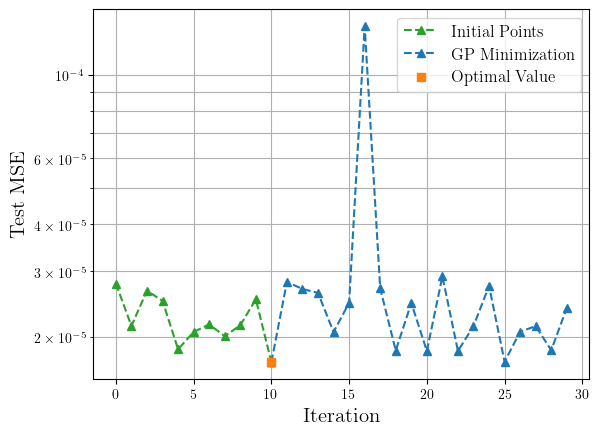

In [37]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/test_mse.pdf', bbox_inches='tight', dpi=300)
plt.show()

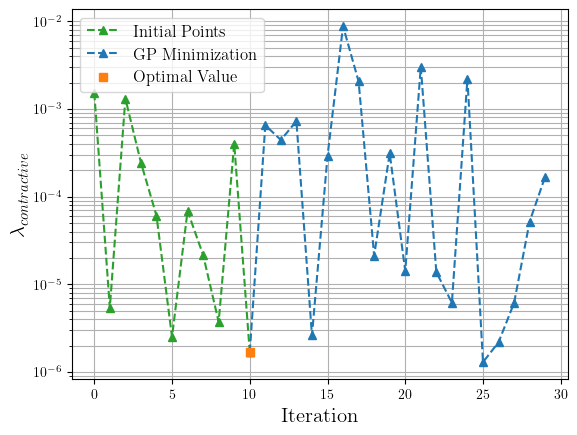

In [38]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        x_iters[:, 0][0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    x_iters[:, 0][a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [x_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('$\lambda_{contractive}$', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/contractive_lmda.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [39]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

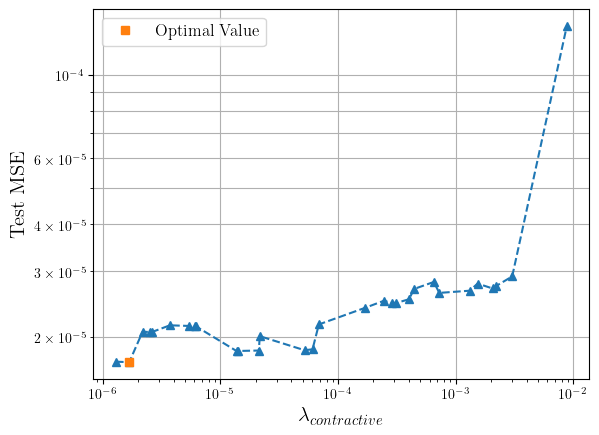

In [40]:
a = 0#n_initial_points
sorted_idx = np.argsort(x_iters[a:, 0])
# sorted_idx = np.arange(x_iters.shape[0]-a)

plt.loglog(
    x_iters[a:, 0][sorted_idx],
    func_iters[a:][sorted_idx],
    label='__nolegend__',
    marker='^',
    linestyle='--',
)
plt.loglog(x_iters[optim_idx, 0], [func_iters[optim_idx]], 's', label='Optimal Value')
plt.xlabel('$\lambda_{contractive}$', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/test_mse_vs_contractive_lmda.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [41]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

In [42]:
# convergence plot
convergence_test_mse = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_test_mse[i] = min_val

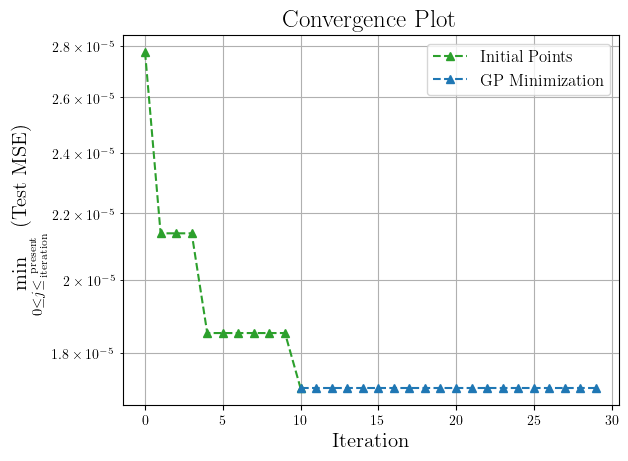

In [43]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        convergence_test_mse[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    convergence_test_mse[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

# KE and Dissipation